# The Impact of AI on Industry
-- **Exploring Future Trends and Opportunities**

Esther Xu

02-20-2024

The project aims to analyze around 200,000 news articles on **Data Science, Machine Learning, and AI** to identify which job roles and industries will most affect AI advancements. Through NLP techniques, we will uncover tasks likely to be automated and areas where AI can boost productivity. The focus includes emerging technologies like image generation and Conversational AI, highlighting a shift towards widespread AI adoption. we will access the data online, analyze it, and provide actionable insights for businesses to navigate the future AI-driven landscape efficiently. The outcome will be strategic recommendations for leveraging AI to adapt to or capitalize on these changes.

In [1]:
#!pip install --upgrade torch sentence-transformers
#!pip install --upgrade bertopic umap-learn hdbscan
#!pip install umap-learn joblib
#!pip install TextBlob

In [2]:
import pandas as pd
import numpy as np
import re
import ktrain
from concurrent.futures import ThreadPoolExecutor
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

os.environ["TOKENIZERS_PARALLELISM"] = "false"

from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import ZeroShotClassification
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired

from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer


from joblib import dump, load, Parallel, delayed
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from collections import defaultdict, Counter

import spacy
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

import matplotlib.colors as colors
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable






pd.set_option('display.max_colwidth', 1000)

In [3]:
import multiprocessing
from pandarallel import pandarallel

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

nb_workers = num_processors - 1
pandarallel.initialize(nb_workers = nb_workers, 
                       use_memory_fs = False, 
                       #progress_bar = True
                      )

Available CPUs: 12
INFO: Pandarallel will run on 11 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [4]:
# Define labels
labels = ['data science', 'machine learning', 'artificial intelligence', 'AI', 'A.I.', ]

# The directories of backup files
backup_dir = '/Users/estherx/Documents/Chicagoo/Courses/NLP/Final Project/data/steps/'
backup_chunk_dir = f'{backup_dir}chunks/'

# 1. Data Preprocessing

In [4]:
%%time

df_raw = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', 
                         engine = 'pyarrow')
df_raw.shape

CPU times: user 3.76 s, sys: 3.78 s, total: 7.54 s
Wall time: 1min 32s


(200435, 5)

In [5]:
df_raw.head()

,url,date,language,title,text
0,http://galusaustralis.com/2020/02/486473/legaltech-artificial-intelligence-market-2019-technology-advancement-and-future-scope-casetext-inc-catalyst-repository-systems-ebrevia/,2020-02-26,en,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020-2026: Apollo Games, Sony, Aristocrat Leisure, IGT\nInfectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher, BD, Roche Diagnostics\nVeterinary Dental X-ray Generators Market Comprehensive Study by Companies Planmeca, Midmark, Medicatech USA\nVeterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik, Gowllands Limited\nVeterinary Holters Market Co..."
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in corporate paid leave policies\n\nNews Parliament\n\nGet the Real Story\n\n \nNews\nTechnology\nServices\nHealthcare\nWorld\nBusiness\nEntertainment\n \n\nWorld \n\n\n \t\t\tChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot \t\t\n\n\n February 27, 2020February 27, 2020\nadmin\t\t\t\t\t\n\n\n 0 Comments\n\n\n Author Recent Posts admin Latest posts by admin (see all) Mansplaining in conferences: How can we get him to forestall? - February 27, 20..."
2,http://www.agoravox.it/Covid-19-un-messaggio-dai.html,2020-03-13,en,Covid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia,\n\n\nCovid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia\n\nAccedi\n\nPartecipa ad AgoraVox!\nIscriviti e proponi un articolo\nHome page\n\n\nAttualitÃ \n\n\nAmbiente\nCronaca\nCronaca Locale\nCultura\nEconomia\nEuropa\nMedia\nIstruzione\nMondo\nPolitica\nSalute\nReligione\nSocietÃ \nScienza e Tecnologia\nTribuna Libera\n\n\tDi' la tua\n\n\nTempo Libero\n\n\nGossip\nRedazionali\nConcorsi\nCinema\nFame&Tulipani\nIncredibile ma vero!\nLa vignetta del giorno\nModa e tendenze\nPubblicazioni AgoraVox\nRecensioni\nSatira\nMusica e Spettacoli\nSport\nViaggi\nChi Siamo\n\n\nContatti\n\n Home page > AttualitÃ > Scienza e Tecnologia > Covid-19: un messaggio dai ricercatori italiani ai colleghi (...)\nCovid-19: un messaggio dai ricercatori italiani ai colleghi stranieri\ndi Pleo\n\t\t\t\t\tvenerdì 13 marzo 2020\n\t\n 0\n \n\nCommenti\n \n 0\n \n\n\nPreferiti\n\nPubblichiamo una lettera redatta a seguito di un'iniziativa di Airic...
3,http://www.desototimes.com/news/child-actor-claude-jarman-jr-looks-back-on-his-movie-career-during-the-golden-days/article_0b310fae-e767-11ec-982e-a380305dda2f.html,2022-06-09,en,Child actor Claude Jarman Jr. looks back on his m

## 1.1 Clean the Data

### 1.1.1 Filter for English-language Texts

In [6]:
df_raw.value_counts('language')

language
en    200435
Name: count, dtype: int64

In [7]:
df_clean = df_raw[df_raw['language'] == 'en'].reset_index()[['date','title', 'text']].copy()

In [8]:
df_clean.head()

,date,title,text
0,2020-02-26,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020-2026: Apollo Games, Sony, Aristocrat Leisure, IGT\nInfectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher, BD, Roche Diagnostics\nVeterinary Dental X-ray Generators Market Comprehensive Study by Companies Planmeca, Midmark, Medicatech USA\nVeterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik, Gowllands Limited\nVeterinary Holters Market Co..."
1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in corporate paid leave policies\n\nNews Parliament\n\nGet the Real Story\n\n \nNews\nTechnology\nServices\nHealthcare\nWorld\nBusiness\nEntertainment\n \n\nWorld \n\n\n \t\t\tChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot \t\t\n\n\n February 27, 2020February 27, 2020\nadmin\t\t\t\t\t\n\n\n 0 Comments\n\n\n Author Recent Posts admin Latest posts by admin (see all) Mansplaining in conferences: How can we get him to forestall? - February 27, 20..."
2,2020-03-13,Covid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia,\n\n\nCovid-19: un messaggio dai ricercatori italiani ai colleghi stranieri - AgoraVox Italia\n\nAccedi\n\nPartecipa ad AgoraVox!\nIscriviti e proponi un articolo\nHome page\n\n\nAttualitÃ \n\n\nAmbiente\nCronaca\nCronaca Locale\nCultura\nEconomia\nEuropa\nMedia\nIstruzione\nMondo\nPolitica\nSalute\nReligione\nSocietÃ \nScienza e Tecnologia\nTribuna Libera\n\n\tDi' la tua\n\n\nTempo Libero\n\n\nGossip\nRedazionali\nConcorsi\nCinema\nFame&Tulipani\nIncredibile ma vero!\nLa vignetta del giorno\nModa e tendenze\nPubblicazioni AgoraVox\nRecensioni\nSatira\nMusica e Spettacoli\nSport\nViaggi\nChi Siamo\n\n\nContatti\n\n Home page > AttualitÃ > Scienza e Tecnologia > Covid-19: un messaggio dai ricercatori italiani ai colleghi (...)\nCovid-19: un messaggio dai ricercatori italiani ai colleghi stranieri\ndi Pleo\n\t\t\t\t\tvenerdì 13 marzo 2020\n\t\n 0\n \n\nCommenti\n \n 0\n \n\n\nPreferiti\n\nPubblichiamo una lettera redatta a seguito di un'iniziativa di Airic...
3,2022-06-09,Child actor Claude Jarman Jr. looks back on his movie career during the “Golden Days” of Hollywood | News | desototimes.com,\nChild actor Claude Jarman Jr. looks back on his movie career during the “Golden Days” of Hollywood | News | desototimes.com\nSkip to main content\n\nYou have permission to edit this article.\n\n Edit\nClose\n\nHome\nNews\n\n\nNews\n\nLocal News\n\nFaith & Worship\n\n\nBusiness\nSports\n\n\nSports\n\nLocal Sports\n\nOutdoor Report\n\nOpinion\n\n\nOpinion\n\nLetters to the Editor\n\nSubmit a Letters to the Editor\n\n\nObituaries\nLifestyle\n\n\nLifestyle\n\nFeatures\n\nCommunity

### 1.1.2 Deal with the content of the title column from the text column

In [9]:
count = (df_clean.parallel_apply(lambda row: row['title'] in row['text'], axis = 1)).sum()
print(f'Number of rows where text contains the title: {count} / {df_clean.shape[0]}')

Number of rows where text contains the title: 194302 / 200435


In [10]:
def remove_title_from_text(title, text):
    # Check if the text starts with the title
    if text.startswith(title):
        # Remove the title from the text
        return text[len(title):].strip() 
    return text

In [11]:
# Create a new column that remove title from text
df_clean['twot'] = df_clean.\
    parallel_apply(lambda row: remove_title_from_text(row['title'], row['text']), axis = 1)

In [12]:
# Create a new column that combines title and text for news articles
df_clean['twt'] = df_clean['title'] + " " + df_clean['twot']


### 1.1.3 Eliminate newlines, tabs, urls and sepcial characters

In [13]:
def clean_text(text):
    text = re.sub(r'\n+', ' ', text)  # replace multiple newlines with space
    text = re.sub(r'\t+', ' ', text)  # replace tabs with space
    text = re.sub(r'http\S+', ' ', text)  # remove URLs
    text = re.sub(r'[^a-zA-Z0-9 @ # . , : - _ % $ ° | ?]', ' ', text)  # remove special characters
    return text.strip()


In [14]:
df_clean['twt'] = df_clean['twt'].parallel_apply(clean_text)
df_clean['twot'] = df_clean['twot'].parallel_apply(clean_text)

In [30]:
df_clean.to_parquet(f'{backup_dir}1_1_3.parquet', engine='pyarrow')

## 1.2 Discard irrelevant articles

We discard articles unrelated to **Data Science, Machine Learning, and AI**, employing Zero-Shot Learning with Natural Language Inference for efficient filtering. Break down the large dataset into manageable files for independent processing. This strategy enhances error management, simplifies retries for failed segments, and enables distributed computing for faster analysis.

In [5]:
df_clean = pd.read_parquet(f'{backup_dir}1_1_3.parquet', engine='pyarrow')
df_clean.head(1)

,date,title,text,twot,twt
0,2020-02-26,"LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope – Casetext Inc., Catalyst Repository Systems, eBREVIA – Galus Australis \n\nGalus Australis\n\nBusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci-Tech\n\nWednesday, February 26 2020\n\nTrending\n\nNeedle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare\nSkin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal\nGlobal Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020-2026: Apollo Games, Sony, Aristocrat Leisure, IGT\nInfectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher, BD, Roche Diagnostics\nVeterinary Dental X-ray Generators Market Comprehensive Study by Companies Planmeca, Midmark, Medicatech USA\nVeterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik, Gowllands Limited\nVeterinary Holters Market Co...","Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci Tech Wednesday, February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020 2026: Apollo Games, Sony, Aristocrat Leisure, IGT Infectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher, BD, Roche Diagnostics Veterinary Dental X ray Generators Market Comprehensive Study by Companies Planmeca, Midmark, Medicatech USA Veterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik, Gowllands Limited Veterinary Holters Market Comprehensive Study by Companies Dextronix, Nasiff Associates Veterinary Test Strips Market Comprehensive Study by Companies Analyticon Biotechnologies, Heska Veterinary Fecal Filter Market C...","LegalTech Artificial Intelligence Market 2019 Technology Advancement and Future Scope Casetext Inc., Catalyst Repository Systems, eBREVIA Galus Australis Galus Australis BusinessGeneral NewsHealthcareIndustryInternationalLifestyleSci Tech Wednesday, February 26 2020 Trending Needle Counters Market Comprehensive Study by Companies Medline Industries, Boen Healthcare Skin Scrub Trays Market Comprehensive Study by Companies Medline Industries, BD, Deroyal Global Portable Handheld Electronic Game Machine Market Outlook and Business Insights 2020 2026: Apollo Games, Sony, Aristocrat Leisure, IGT Infectious Disease Testing Using PCR for IVD Market Comprehensive Study by Companies Thermo Fisher, BD, Roche Diagnostics Veterinary Dental X ray Generators Market Comprehensive Study by Companies Planmeca, Midmark, Medicatech USA Veterinary Ophthalmoscopes Market Comprehensive Study by Companies Heine Optotechnik, Gowllands Limited Veterinary Holters Market Comprehensive Study by Companies ..."


In [6]:
# 1.Divide the Dataset into Several Files

chunk_size = 5000  # Number of rows per chunk/file
chunks = [df_clean[i:i + chunk_size] for i in range(0, df_clean.shape[0], chunk_size)]

for i, chunk in enumerate(chunks):
    chunk.to_parquet(f'{backup_chunk_dir}chunk_1_2_{i}.parquet', engine='pyarrow')


In [5]:
# 2. Process Each File with ZSL Predictions

def process_chunk(file_path, output_path):
    try:
        # Load the dataset
        df = pd.read_parquet(file_path, engine='pyarrow')
        articles_list = df['twt'].tolist()
        
        # Initialize the ZeroShotClassifier
        zsl = ktrain.text.ZeroShotClassifier()
        
        # Generate predictions
        predictions = zsl.predict(articles_list, 
                                  labels = labels, 
                                  include_labels = True, 
                                  multilabel = True, 
                                  batch_size = 256)
        
        # Identify relevant articles based on prediction scores
        relevant_indices = []
        prediction_scores = []  # To store the highest score for each prediction
        
        for idx, prediction in enumerate(predictions):
            # Find the max score among the predictions for this article
            max_score = max(pred[1] for pred in prediction) if prediction else 0
            prediction_scores.append(max_score)
            
            if any(pred[1] > 0.5 for pred in prediction):
                relevant_indices.append(idx)
        
        # Filter the DataFrame to only include relevant articles and explicitly create a copy
        df_relevant = df.iloc[relevant_indices].copy()  # Use .copy() here
        
        # Add a column for the highest prediction score
        df_relevant['max_prediction_score'] = [prediction_scores[i] for i in relevant_indices]
        
        # Save the filtered DataFrame with predictions to the output file
        df_relevant.to_parquet(output_path, engine='pyarrow')
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        
        # Log failed file paths for later review
        with open("failed_files.txt", "a") as file:
            file.write(file_path + "\n")


In [7]:
# 3. Parallel Processing of Files

def get_file_paths(directory):
    return [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.startswith('chunk_')]

def main():
    
    file_paths = get_file_paths(backup_chunk_dir)
    
    with ThreadPoolExecutor(max_workers = nb_workers) as executor:  
        futures = [executor.submit(process_chunk, file_path, file_path.replace('chunk_', 'relevant_')) for file_path in file_paths]
    

if __name__ == "__main__":
    main()


In [29]:
# 4.Combining Results 

def combine_relevant_files(directory):
    relevant_files = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.startswith('relevant_')]
    df_combined = pd.concat([pd.read_parquet(file, engine = 'pyarrow') for file in relevant_files], ignore_index=True)
    df_combined.to_parquet(f'{backup_dir}1_2.parquet', engine = 'pyarrow')

combine_relevant_files(backup_chunk_dir)


In [9]:
df_filter = pd.read_parquet(f'{backup_dir}1_2.parquet', engine='pyarrow')
df_filter.head(1)

,date,title,text,twot,twt,max_prediction_score
0,2023-07-11,"Shutterstock Expands Partnership with OpenAI, Signs New Six-Year Agreement to Provide High-Quality Training Data","Shutterstock Expands Partnership with OpenAI, Signs New Six-Year Agreement to Provide High-Quality Training Data\n\nSkip to contentContact TroubleshootersTrafficFocus on HealthListens LiveLegal BriefYour MoneyJob LinkMake Ends MeetDerby City WeekendContestsNewsWeatherWAVE NowVideoBehind the BearSportsDecision 2023TroubleshootersAbout UsHomeVideoWatch LiveWAVE AppsNewsKentuckyIndianaRegionalNationalDecision 2023Positively WAVECoronavirusPoliticalCrimeLouisville Mass ShootingBreonna TaylorEducationApp ExtraTroubleshootersInvestigationsContact UsBehind the BearLocalLouisville MetroHardin CountyOldham CountySpencer CountyFloyd CountyScott CountyBullitt CountyNelson CountyShelby CountyClark CountyHarrison CountyWeatherRadarClosingsClosings RequestSkyTrack CamerasWeather BlogHokey Weather FactsEducationTrafficGas PricesCommunityDerby City WeekendWAVE CountryCalendarSubmit Your PhotosMake Ends MeetSportsNCAASports VideoGame OnDigital Derby GuideStats & PredictionsHow to WatchFoodSecrets o...",Skip to contentContact TroubleshootersTrafficFocus on HealthListens LiveLegal BriefYour MoneyJob LinkMake Ends MeetDerby City WeekendContestsNewsWeatherWAVE NowVideoBehind the BearSportsDecision 2023TroubleshootersAbout UsHomeVideoWatch LiveWAVE AppsNewsKentuckyIndianaRegionalNationalDecision 2023Positively WAVECoronavirusPoliticalCrimeLouisville Mass ShootingBreonna TaylorEducationApp ExtraTroubleshootersInvestigationsContact UsBehind the BearLocalLouisville MetroHardin CountyOldham CountySpencer CountyFloyd CountyScott CountyBullitt CountyNelson CountyShelby CountyClark CountyHarrison CountyWeatherRadarClosingsClosings RequestSkyTrack CamerasWeather BlogHokey Weather FactsEducationTrafficGas PricesCommunityDerby City WeekendWAVE CountryCalendarSubmit Your PhotosMake Ends MeetSportsNCAASports VideoGame OnDigital Derby GuideStats PredictionsHow to WatchFoodSecrets of Bluegrass ChefsAbout UsMeet the TeamNEXTGEN TVJoin Our TeamStation HistoryContact UsAdvertise With UsProgram Sched...,"Shutterstock Expands Partnership with OpenAI, Signs New Six Year Agreement to Provide High Quality Training Data Skip to contentContact TroubleshootersTrafficFocus on HealthListens LiveLegal BriefYour MoneyJob LinkMake Ends MeetDerby City WeekendContestsNewsWeatherWAVE NowVideoBehind the BearSportsDecision 2023TroubleshootersAbout UsHomeVideoWatch LiveWAVE AppsNewsKentuckyIndianaRegionalNationalDecision 2023Positively WAVECoronavirusPoliticalCrimeLouisville Mass ShootingBreonna TaylorEducationApp ExtraTroubleshootersInvestigationsContact UsBehind the BearLocalLouisville MetroHardin CountyOldham CountySpencer CountyFloyd CountyScott CountyBullitt CountyNelson CountyShelby CountyClark CountyHarrison CountyWeatherRadarClosingsClosings RequestSkyTrack CamerasWeather BlogHokey Weather FactsEducationTrafficGas PricesCommunityDerby City WeekendWAVE CountryCalendarSubmit Your PhotosMake Ends MeetSportsNCAASports VideoGame OnDigital Derby GuideStats PredictionsHow to WatchFoodSecrets of B...",0.999578


In [17]:
#df_filter[df_filter['max_prediction_score'] <= 0.502]


# 2. Topics Major Detection

In [10]:
docs_twt = df_filter['twt'].tolist()

## 2.1 Build BERTopic Model

#### Step 1 - Extract embeddings: Pre-calculate embeddings

In [8]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")


Batches:   0%|          | 0/5391 [00:00<?, ?it/s]

In [15]:
embeddings = embedding_model_loaded.encode(docs_twt, show_progress_bar = True)

Batches:   0%|          | 0/5391 [00:00<?, ?it/s]

In [11]:
# Save embedding model
embedding_model.save(f'{backup_dir}embedding_model')

np.save(f'{backup_dir}embeddings.npy', embeddings)

In [417]:
# Load embedding model 
embedding_model_loaded = SentenceTransformer(f'{backup_dir}embedding_model')

In [5]:
# Load the embeddings back
embeddings_loaded = np.load(f'{backup_dir}embeddings.npy')

#### Step 2 - Reduce dimensionality: Preventing Stochastic Behavior

In [15]:
# Define ranges for UMAP parameters
n_neighbors_values = [5, 15, 30, 50]
n_components_values = [2, 5, 10]
min_dist_values = [0.0, 0.1, 0.5, 0.99]

best_config_umap = {}
best_silhouette_umap = -1

for n_neighbors in n_neighbors_values:
    for n_components in n_components_values:
        for min_dist in min_dist_values:
            # Initialize and fit UMAP
            reducer = UMAP(n_neighbors = n_neighbors, n_components = n_components,
                           min_dist = min_dist, metric = 'cosine', random_state = 42)
            reduced_embeddings = reducer.fit_transform(embeddings)

            # Apply HDBSCAN on the reduced embeddings
            clusterer = HDBSCAN(min_cluster_size = 15, 
                                metric = 'euclidean', 
                                cluster_selection_method = 'eom', 
                                prediction_data = True)
            labels = clusterer.fit_predict(reduced_embeddings)

            # Calculate silhouette score only if more than one cluster is found
            if len(set(labels)) > 1:
                score = silhouette_score(reduced_embeddings, labels, metric = 'euclidean')
                
                if score > best_silhouette_umap:
                    best_silhouette_umap = score
                    best_config_umap = {
                        'n_neighbors': n_neighbors,
                        'n_components': n_components,
                        'min_dist': min_dist,
                        'silhouette_score': score
                    }

print("Best Configuration:", best_config_umap)

Best Configuration: {'n_neighbors': 5, 'n_components': 2, 'min_dist': 0.0, 'silhouette_score': 0.31861615}


In [16]:
# Create UMAP model with optimized parameters
umap_model = UMAP(n_neighbors = best_config_umap['n_neighbors'],
                       n_components = best_config_umap['n_components'],
                       min_dist = best_config_umap['min_dist'],
                       metric = 'cosine', 
                       random_state = 42)


In [19]:
dump(umap_model, f'{backup_dir}umap_model.joblib')

['umap_model.joblib']

In [9]:
umap_model_loaded = load(f'{backup_dir}umap_model.joblib')

#### Step 3 - Cluster reduced embeddings: Controlling Number of Topics

In [23]:
# Experiment with different min_cluster_size values
min_cluster_sizes = [15, 30, 50, 100]
best_silhouette_hdbscan = -1
best_config_hdbscan = None

for min_cluster_size in min_cluster_sizes:
    hdbscan_model = HDBSCAN(min_cluster_size = min_cluster_size,
                            metric = 'euclidean',
                            cluster_selection_method = 'eom',
                            prediction_data = True)
    labels = hdbscan_model.fit_predict(embeddings)  
    
    # Ensure there's more than one cluster (excluding noise)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_clusters > 1:
        # Calculate silhouette score
        score = silhouette_score(embeddings, labels)  # Use embeddings for silhouette score
        print(f"min_cluster_size: {min_cluster_size}, clusters: {n_clusters}, silhouette score: {score}")
        
        # Update best configuration based on silhouette score
        if score > best_silhouette_hdbscan:
            best_silhouette_hdbscan = score
            best_config_hdbscan = {
                'min_cluster_size': min_cluster_size,
                'clusters': n_clusters,
                'silhouette_score': score
            }
    else:
        print(f"min_cluster_size: {min_cluster_size} results in a single cluster.")


min_cluster_size: 15, clusters: 2, silhouette score: 0.08056090772151947
min_cluster_size: 30, clusters: 2, silhouette score: 0.05134592950344086
min_cluster_size: 50, clusters: 2, silhouette score: 0.04851720854640007
min_cluster_size: 100, clusters: 2, silhouette score: 0.04384821280837059


In [24]:
if best_config_hdbscan:
    print("Best Configuration:", best_config_hdbscan)
    
    hdbscan_model = HDBSCAN(min_cluster_size = best_config_hdbscan['min_cluster_size'],
                            metric = 'euclidean',
                            cluster_selection_method = 'eom',
                            prediction_data = True)
else:
    print("No valid clustering configuration found.")

Best Configuration: {'min_cluster_size': 15, 'clusters': 2, 'silhouette_score': 0.08056091}


In [25]:
dump(hdbscan_model, f'{backup_dir}hdbscan_model.joblib')

['/Users/estherx/Documents/Chicagoo/Courses/NLP/Final Project/data/steps/hdbscan_model.joblib']

In [10]:
hdbscan_model_loaded = load(f'{backup_dir}hdbscan_model.joblib')


#### Step 4: Tokenize topics: Improving Default Representation

In [40]:
def calculate_coherence_score(model, documents):

    topics = model.get_topics()
    
    # Assuming `get_topic()` returns a list of tuples (word, score) for the given topic number
    topic_words = [[word for word, _ in topics[topic]] for topic in topics if topic != -1]  # Exclude outlier topic if exists

    # Preprocess documents for Gensim compatibility
    documents = [doc.split() for doc in documents]  # Split documents into lists of words

    # Create a Gensim dictionary and corpus
    dictionary = Dictionary(documents)
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    # Convert topic words to their token IDs in the dictionary
    topic_terms = [[dictionary.token2id[word] for word in topic if word in dictionary.token2id] for topic in topic_words]

    # Ensure all topic terms are in the dictionary
    topic_terms = [topic for topic in topic_terms if len(topic) > 0]
    
    if not topic_terms:
        return np.nan  # Return NaN if all topics are filtered out

    # Calculate coherence score using Gensim's CoherenceModel
    coherence_model = CoherenceModel(topics=topic_terms, texts=documents, corpus=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    return coherence_score


In [44]:
ngram_ranges = [(1, 2), (1, 3)]
min_df_values = [2, 5, 10]
best_configuration_vec = {'ngram_range': None, 'min_df': None}
best_score_vec = float('-inf')

for ngram_range in ngram_ranges:
    for min_df in min_df_values:
        vectorizer_model = CountVectorizer(stop_words = "english", 
                                           min_df = min_df, 
                                           ngram_range = ngram_range)
        bertopic_model = BERTopic(embedding_model = embedding_model_loaded,    
                                  vectorizer_model =vectorizer_model, 
                                  verbose = True)
        topics, _ = bertopic_model.fit_transform(docs_twt)
        
        # Calculate coherence score 
        coherence_score = calculate_coherence_score(bertopic_model, docs_twt)
        
        print(f"Configuration: ngram_range={ngram_range}, min_df={min_df}, Coherence Score={coherence_score}")
        
        if coherence_score > best_score_vec:
            best_score_vec = coherence_score
            best_configuration_vec['ngram_range'] = ngram_range
            best_configuration_vec['min_df'] = min_df

print(f"Best Configuration: ngram_range={best_configuration_vec['ngram_range']}, min_df={best_configuration_vec['min_df']} with Coherence Score={best_score_vec}")


2024-02-26 19:02:47,460 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/5391 [00:00<?, ?it/s]

2024-02-26 19:16:43,726 - BERTopic - Embedding - Completed ✓
2024-02-26 19:16:43,726 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-26 19:17:23,473 - BERTopic - Dimensionality - Completed ✓
2024-02-26 19:17:23,477 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-26 19:17:31,719 - BERTopic - Cluster - Completed ✓
2024-02-26 19:17:31,742 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-26 19:21:54,985 - BERTopic - Representation - Completed ✓
2024-02-26 19:42:28,138 - BERTopic - Embedding - Transforming documents to embeddings.


Configuration: ngram_range=(1, 2), min_df=2, Coherence Score=0.626593685595242


Batches:   0%|          | 0/5391 [00:00<?, ?it/s]

2024-02-26 19:55:58,418 - BERTopic - Embedding - Completed ✓
2024-02-26 19:55:58,418 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-26 19:56:46,587 - BERTopic - Dimensionality - Completed ✓
2024-02-26 19:56:46,591 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-26 19:56:55,263 - BERTopic - Cluster - Completed ✓
2024-02-26 19:56:55,288 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-26 20:01:02,410 - BERTopic - Representation - Completed ✓
2024-02-26 20:23:35,453 - BERTopic - Embedding - Transforming documents to embeddings.


Configuration: ngram_range=(1, 2), min_df=5, Coherence Score=0.6045836787175413


Batches:   0%|          | 0/5391 [00:00<?, ?it/s]

2024-02-26 20:37:06,283 - BERTopic - Embedding - Completed ✓
2024-02-26 20:37:06,284 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-26 20:37:56,785 - BERTopic - Dimensionality - Completed ✓
2024-02-26 20:37:56,788 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-26 20:38:05,287 - BERTopic - Cluster - Completed ✓
2024-02-26 20:38:05,313 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-26 20:42:04,049 - BERTopic - Representation - Completed ✓
2024-02-26 21:06:53,575 - BERTopic - Embedding - Transforming documents to embeddings.


Configuration: ngram_range=(1, 2), min_df=10, Coherence Score=0.5631168004569612


Batches:   0%|          | 0/5391 [00:00<?, ?it/s]

2024-02-26 21:20:23,624 - BERTopic - Embedding - Completed ✓
2024-02-26 21:20:23,624 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-26 21:21:03,038 - BERTopic - Dimensionality - Completed ✓
2024-02-26 21:21:03,042 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-26 21:21:11,406 - BERTopic - Cluster - Completed ✓
2024-02-26 21:21:11,430 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-26 21:28:25,095 - BERTopic - Representation - Completed ✓
2024-02-26 21:55:46,969 - BERTopic - Embedding - Transforming documents to embeddings.


Configuration: ngram_range=(1, 3), min_df=2, Coherence Score=0.64770625913844


Batches:   0%|          | 0/5391 [00:00<?, ?it/s]

2024-02-26 22:09:09,452 - BERTopic - Embedding - Completed ✓
2024-02-26 22:09:09,452 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-26 22:09:51,480 - BERTopic - Dimensionality - Completed ✓
2024-02-26 22:09:51,485 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-26 22:09:59,828 - BERTopic - Cluster - Completed ✓
2024-02-26 22:09:59,852 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-26 22:16:44,845 - BERTopic - Representation - Completed ✓
2024-02-26 22:45:38,581 - BERTopic - Embedding - Transforming documents to embeddings.


Configuration: ngram_range=(1, 3), min_df=5, Coherence Score=0.6246299509270744


Batches:   0%|          | 0/5391 [00:00<?, ?it/s]

2024-02-26 22:59:03,500 - BERTopic - Embedding - Completed ✓
2024-02-26 22:59:03,500 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-26 22:59:44,644 - BERTopic - Dimensionality - Completed ✓
2024-02-26 22:59:44,648 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-26 22:59:52,963 - BERTopic - Cluster - Completed ✓
2024-02-26 22:59:52,988 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-26 23:06:32,845 - BERTopic - Representation - Completed ✓


Configuration: ngram_range=(1, 3), min_df=10, Coherence Score=0.5746103325609208
Best Configuration: ngram_range=(1, 3), min_df=2 with Coherence Score=0.64770625913844


In [45]:
vectorizer_model = CountVectorizer(stop_words = "english",
                                   min_df = best_configuration_vec['min_df'], 
                                   ngram_range = best_configuration['ngram_range'])

In [47]:
# Save the model
dump(vectorizer_model, f'{backup_dir}vectorizer_model.joblib')


['/Users/estherx/Documents/Chicagoo/Courses/NLP/Final Project/data/steps/vectorizer_model.joblib']

In [19]:
vectorizer_model_loaded = load(f'{backup_dir}vectorizer_model.joblib')


#### Step 5: Create topic representation: Extract topic words

In [12]:
ctfidf_model = ClassTfidfTransformer()

#### Step 6: Fine-tune topic representations with a 'bertopic.representation' model

In [13]:
# The main representation of a topic
main_representation = KeyBERTInspired()


# Create my representation model
aspect_model1 = ZeroShotClassification(labels, model = "facebook/bart-large-mnli")

# Add all models together to be run in a single `fit`
representation_model = {
   "Main": main_representation,
   "Aspect1":  aspect_model1,
}



#### All steps together

In [19]:
bertopic_model = BERTopic(
  language = "english",
  calculate_probabilities = False,
  verbose = True,
  #n_gram_range = (1, 3),
  embedding_model = embedding_model_loaded,          # Step 1 - Extract embeddings
  umap_model = umap_model_loaded,                    # Step 2 - Reduce dimensionality
  hdbscan_model = hdbscan_model_loaded,              # Step 3 - Cluster reduced embeddings
  vectorizer_model = vectorizer_model_loaded,        # Step 4 - Tokenize topics
  ctfidf_model = ctfidf_model,                # Step 5 - Extract topic words
  representation_model = representation_model # Step 6 - Fine-tune topic represenations
)



In [21]:
topics, probs = bertopic_model.fit_transform(docs_twt, embeddings_loaded)

2024-02-28 11:53:06,238 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-02-28 11:54:53,632 - BERTopic - Dimensionality - Completed ✓
2024-02-28 11:54:53,634 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-02-28 11:54:58,488 - BERTopic - Cluster - Completed ✓
2024-02-28 11:54:58,511 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-02-28 12:39:00,458 - BERTopic - Representation - Completed ✓


- **Save BERTopic Model**

In [22]:
# Save bertopic_model
bertopic_model.save(f"{backup_dir}bertopic_model_v2", 
                 serialization = "pytorch", 
                 save_ctfidf = True, 
                 save_embedding_model = embedding_model_loaded)



In [30]:
# Save 'topic_id'
df_filter['topic_id'] = topics

df_filter.to_parquet(f"{backup_dir}2_v2.parquet")

In [26]:
# Save topics and probabilities
dump(topics, f'{backup_dir}topics_v2.joblib')
dump(probs, f'{backup_dir}probs_v2.joblib')


['/Users/estherx/Documents/Chicagoo/Courses/NLP/Final Project/data/steps/probs_v2.joblib']

In [63]:
# Save Representative Documents
representative_docs  = bertopic_model.get_representative_docs()

rep_docs_df = pd.DataFrame(list(representative_docs.items()), columns=['Topic', 'Representative_Docs'])
rep_docs_df.to_parquet(f"{backup_dir}2_representative_docs_v2.parquet")


- **Load BERTopic Model**

In [30]:
# Load bertopic_model
bertopic_model_loaded = BERTopic.load(f"{backup_dir}bertopic_model_v2",
                                      embedding_model = embedding_model_loaded)


2024-02-28 22:18:00,902 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


In [31]:
# Check Loaded topic info
freq = bertopic_model_loaded.get_topic_info()
print(f"Topics found: {freq.shape[0]}")

freq.head()

Topics found: 2639


,Topic,Count,Name,Representation,Aspect1,Representative_Docs
0,-1,38852,-1_industry_tech_technologies_services,"[industry, tech, technologies, services, technology, service, companies, future, ai, cloud]","[industry, tech, technologies, services, technology, service, companies, future, ai, cloud]",NaN
1,0,1580,0_market 2020_artificial intelligence market_market 2021_ai market,"[market 2020, artificial intelligence market, market 2021, ai market, intelligence market, market research report, software market, market report, analysis forecast, forecast 2026]","[market 2020, artificial intelligence market, market 2021, ai market, intelligence market, market research report, software market, market report, analysis forecast, forecast 2026]",NaN
2,1,1364,1_chatgpt openai_openai chatgpt_chatgpt ai_openai gpt,"[chatgpt openai, openai chatgpt, chatgpt ai, openai gpt, chatgpt enterprise, openai, ai chatbot, ai chatbots, like chatgpt, chatgpt]","[chatgpt openai, openai chatgpt, chatgpt ai, openai gpt, chatgpt enterprise, openai, ai chatbot, ai chatbots, like chatgpt, chatgpt]",NaN
3,2,968,2_auto transportation_business technology_transportation_heavy industry,"[auto transportation, business technology, transportation, heavy industry, industry manufacturing, heavy industry manufacturing, services investing, mining, financial services investing, consumer technology]","[auto transportation, business technology, transportation, heavy industry, industry manufacturing, heavy industry manufacturing, services investing, mining, financial services investing, consumer technology]",NaN
4,3,868,3_communitynewsletterthe best product_product hunt teamoffice_product teamvisit_coming soonproduct questionsanswer,"[communitynewsletterthe best product, product hunt teamoffice, product teamvisit, coming soonproduct questionsanswer, hoursgive feedback, best product hunt, directly product teamvisit, productscoming sooncheck launches, product hunt productscoming, hunt teamoffice hoursgive]","[communitynewsletterthe best product, product hunt teamoffice, product teamvisit, coming soonproduct questionsanswer, hoursgive feedback, best product hunt, directly product teamvisit, productscoming sooncheck launches, product hunt productscoming, hunt teamoffice hoursgive]",NaN


In [32]:
# Load Representative Documents
rep_docs_df = pd.read_parquet(f"{backup_dir}2_representative_docs_v2.parquet")

# Combine Representative Docusments with loaded bertopic model(since loaded bertopic model without Representative_Docs)
freq = bertopic_model_loaded.get_topic_info()
freq.drop('Representative_Docs', axis = 1, inplace = True)
freq = freq.merge(rep_docs_df[['Topic', 'Representative_Docs']], on='Topic', how='left')

print(f"Topics found: {freq.shape[0]}")

freq.head()

Topics found: 2639


,Topic,Count,Name,Representation,Aspect1,Representative_Docs
0,-1,38852,-1_industry_tech_technologies_services,"[industry, tech, technologies, services, technology, service, companies, future, ai, cloud]","[industry, tech, technologies, services, technology, service, companies, future, ai, cloud]","[2023 CAQH Index Reveals Transformative Forces: Staffing Shortages, Hybrid Work, Cyber Threats and AI Drive a 50% YOY Increase in Healthcare Administration Costs and Complexities 2023 CAQH Index Reveals Transformative Forces: Staffing Shortages, Hybrid Work, Cyber Threats and AI Drive a 50% YOY Increase in Healthcare Administration Costs and Complexities Resources Blog Journalists Log In Sign Up Data Privacy Send a Release News Products Contact Search Search When typing in this field, a list of search results will appear and be automatically updated as you type. Searching for your content... No results found. Please change your search terms and try again. News in Focus Browse News Releases All News Releases All Public Company English only News Releases Overview Multimedia Gallery All Multimedia All Photos All Videos Multimedia Gallery Overview Trending Topics All Trending Topics Business Money Auto TransportationAll Automotive Transportation Aerospace, Defen..."
1,0,1580,0_market 2020_artificial intelligence market_market 2021_ai market,"[market 2020, artificial intelligence market, market 2021, ai market, intelligence market, market research report, software market, market report, analysis forecast, forecast 2026]","[market 2020, artificial intelligence market, market 2021, ai market, intelligence market, market research report, software market, market report, analysis forecast, forecast 2026]","[Artificial Intelligence Market Overview With Detailed Analysis, Competitive Landscape, Forecast 2025 Welltok, Inc., Intel Corporation, Nvidia Corporation, Google Inc., Ibm Corporation Illadel Graff Supply Artificial Intelligence Market Overview With Detailed Analysis, Competitive Landscape, Forecast 2025 Welltok, Inc., Intel Corporation, Nvidia Corporation, Google Inc., Ibm Corporation Illadel Graff Supply Friday, November 6 2020 Breaking News High pressure Processing HPP Equipment Market by Technology, Application Geography Analysis Forecast to 2026 Biden or Trump?: Four states decide who wins world Global Centrifugal Chiller Market by Manufacturers, Countries, Type and Application, Forecast to 2026 Global Water Cooled Centrifugal Chillers Market Size, Share, Trend Growth Forecast to 2026 Belt Press Filter equipment Market Industry Analysis, Size, Share, Growth, Trends, Forecast 2020 2026 Research delivers insight into the global Marine Cooler market du..."
2,1,1364,1_chatgpt openai_openai chatgpt_chatgpt ai_openai gpt,"[chatgpt openai, openai chatgpt, chatgpt ai, openai gpt, chatgpt enterprise, openai, ai chatbot, ai chatbots, like chatgpt, chatgpt]","[chatgpt openai, openai chatgpt, chatgpt ai, openai gpt, chatgpt enterprise, openai, ai chatbot, ai chatbots, like chatgpt, chatgpt]","[ChatGPT: Everything you need to know about the AI powered chatbot ChatGPT: Everything you need to know about the AI powered chatbot ChatGPT: Everything you need to know about the AI powered chatbot Alyssa Stringer Kyle Wiggers 14 hours ChatGPT, OpenAI s text generating AI chatbot, has taken the world by storm. It s able to write essays, code and more given short text prompts, hyper charging productivity. But it also has a more nefarious side. In any case, AI tools are not going away and indeed has expanded dramatically since its launch just a few months ago. Major brands are experimenting with it, using the AI to generate ad and marketing copy, for example. And OpenAI is heavily investing in it. ChatGPT was recently super charged by GPT 4, the latest language writing model from OpenAI s labs. Paying ChatGPT users have access to GPT 4, which can write more naturally and fluently than the model that previously powered ChatGPT. In addition to GPT 4, OpenAI rec

In [33]:
bertopic_model_loaded.get_topic(0)

[['market 2020', 0.569060206413269],
 ['artificial intelligence market', 0.5627388954162598],
 ['market 2021', 0.5565543174743652],
 ['ai market', 0.5517854690551758],
 ['intelligence market', 0.5408183932304382],
 ['market research report', 0.5340161919593811],
 ['software market', 0.5008211135864258],
 ['market report', 0.4767814874649048],
 ['analysis forecast', 0.47041183710098267],
 ['forecast 2026', 0.4666668772697449]]

## 2.2 Reduce Topics

In [11]:
len(docs_twt)

172481

In [34]:
bertopic_model_loaded.reduce_topics(docs_twt, nr_topics = "auto")

2024-02-28 22:18:25,818 - BERTopic - Topic reduction - Reducing number of topics
2024-02-28 22:26:32,258 - BERTopic - Topic reduction - Reduced number of topics from 2639 to 329


In [35]:
reduced_topics, _ = bertopic_model_loaded.transform(docs_twt)

Batches:   0%|          | 0/5391 [00:00<?, ?it/s]

2024-02-28 22:40:34,379 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [55]:
count_minus_1 = np.count_nonzero(reduced_topics == -1)
print("Count of -1:", count_minus_1)

Count of -1: 43993


- **Save Reduced Model**

In [38]:
### Save df_filter after reducing
df_filter['topic_id_reduced'] = reduced_topics

df_filter.to_parquet(f"{backup_dir}2_with_reduced_id_v2.parquet")

In [44]:
### Save bertopic_model after reducing
bertopic_model_loaded.save(f"{backup_dir}bertopic_model_reduced_v2", 
                    serialization = "pytorch", 
                    save_ctfidf = True, 
                    save_embedding_model = True) 


In [46]:
# Save Representative Documents after reducing
representative_docs_reduced  = bertopic_model_loaded.get_representative_docs()

rep_docs_reduced_df = pd.DataFrame(list(representative_docs_reduced.items()), columns=['Topic', 'Representative_Docs'])
rep_docs_reduced_df.to_parquet(f"{backup_dir}2_representative_docs_reduced_v3.parquet")


- **Load Reduced Model**

In [418]:
bertopic_model_reduced_loaded = BERTopic.load(f"{backup_dir}bertopic_model_reduced_v2",
                                      embedding_model = embedding_model_loaded)


2024-03-03 09:19:23,705 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


In [8]:
bertopic_model_reduced_loaded.get_topic_info().head(1)

,Topic,Count,Name,Representation,Aspect1,Representative_Docs
0,-1,38852,-1_ai_news_data_new,"[ai, news, data, new, technology, intelligence, 2023, market, business, artificial]","[industry, tech, technologies, services, technology, service, companies, future, ai, cloud]",NaN


In [419]:
# Load Representative Documents
rep_docs_reduced_df = pd.read_parquet(f"{backup_dir}2_representative_docs_reduced_v3.parquet")

# Combine Representative Docusments with loaded bertopic model(since loaded bertopic model without Representative_Docs)

freq_reduced = bertopic_model_reduced_loaded.get_topic_info()
freq_reduced.drop('Representative_Docs', axis = 1, inplace = True)
freq_reduced = freq_reduced.merge(rep_docs_reduced_df[['Topic', 'Representative_Docs']], on='Topic', how='left')


In [420]:
print(f"Topics found: {freq_reduced.shape[0]}")

freq_reduced.head(1)

Topics found: 329


,Topic,Count,Name,Representation,Aspect1,Representative_Docs
0,-1,38852,-1_ai_news_data_new,"[ai, news, data, new, technology, intelligence, 2023, market, business, artificial]","[industry, tech, technologies, services, technology, service, companies, future, ai, cloud]","[Huawei s Joy Tan to Discuss AI Climate Solutions at Foreign Policy s Virtual Climate Summit Huawei s Joy Tan to Discuss AI Climate Solutions at Foreign Policy s Virtual Climate Summit Resources Blog Journalists Log In Sign Up Data Privacy Send a Release News Products Overview Distribution by PR Newswire Cision Communications Cloud Cision IR All Products Contact General Inquiries Request a Demo Editorial Bureaus Partnerships Media Inquiries Worldwide Offices Search Search When typing in this field, a list of search results will appear and be automatically updated as you type. Searching for your content... No results found. Please change your search terms and try again. News in Focus Browse News Releases All News Releases All Public Company English only News Releases Overview Multimedia Gallery All Multimedia All Photos All Videos Multimedia Gallery Overview Trending Topics All Trending Topics Business Money Auto TransportationAll Automotive Transportatio..."


In [421]:
fig = bertopic_model_reduced_loaded.visualize_topics()
fig.show(renderer='iframe')

In [12]:
df_filter_1 = pd.read_parquet(f'{backup_dir}2_with_reduced_id_v2.parquet', engine='pyarrow')
# df_filter_1.head(1)

## 2.3 Categorize Topics into Broader Themes

- **Step 1: Vectorize the Keywords**

In [14]:
topics_reduced = bertopic_model_reduced_loaded.get_topics()

# Extract top N words for each updated topic
top_n_words = {topic: [word for word, _ in words] for topic, words in topics_reduced.items() if topic >= 0}  # filter out -1 (outliers)
topic_words = list(top_n_words.values())  # Only the words

In [17]:
# Flatten each list of keywords into a string
topic_keywords_str = [" ".join(topic) for topic in topic_words]

# Create a TF-IDF representation of the keywords
vectorizer_themes = TfidfVectorizer()
tfidf_matrix = vectorizer_themes.fit_transform(topic_keywords_str)


- **Step 2: Cluster the Topics**

In [27]:
number_of_clusters = 20

# Perform KMeans clustering
kmeans = KMeans(n_clusters=number_of_clusters, random_state=42)
kmeans.fit(tfidf_matrix)

# Get the cluster labels for each topic
clusters = kmeans.labels_


- **Step 3: Label the Clusters**

In [28]:
# Group topics by their cluster labels

clustered_topics = defaultdict(list)
for topic_id, cluster_id in enumerate(clusters):
    clustered_topics[cluster_id].append(topic_id)

In [29]:
# Interpret each cluster and assign a label to it
for cluster_id, topic_ids in clustered_topics.items():
    # Print out the keywords for each topic in the cluster
    print(f"Cluster {cluster_id}:")
    
    for topic_id in topic_ids:
        print(f" - Topic {topic_id}: {topic_words[topic_id]}")
 

Cluster 12:
 - Topic 0: ['ai', 'market', 'news', 'data', 'new', 'intelligence', '2023', 'artificial', 'artificial intelligence', 'technology']
 - Topic 69: ['earlysign', 'philippine', 'teodoro', 'security risks', 'ordered', 'defense', 'ordered defense', 'refrain using', 'stop using artificial', 'military ordered stop']
 - Topic 105: ['delaware', 'crowded beaches', 'beaches', 'crowded', 'evacuation', 'beaches floods', 'evacuate crowded beaches', 'crowded beaches floods', 'evacuate crowded', 'intelligence evacuate']
 - Topic 173: ['allianzgi', 'allianzgi artificial', 'allianzgi artificial intelligence', 'virtus allianzgi', 'virtus allianzgi artificial', 'opportunities fund', 'technology opportunities fund', 'intelligence technology opportunities', 'technology opportunities', 'virtus']
 - Topic 193: ['juana summers', 'juana', 'holocaust', 'summers', 'npr', 'justine kenin', 'kenin', 'connect holocaust', 'survivor photos', 'intelligence helped connect']
 - Topic 260: ['asterra', 'lithium', 

- **Step 4: Create a Mapping from Clusters to Themes**

In [34]:
# 1: Aggregate keywords by cluster
cluster_keywords = {cluster_id: [keyword for topic_id in topic_ids for keyword in topic_words[topic_id]] 
                    for cluster_id, topic_ids in clustered_topics.items()}

# 2: Perform keyword frequency analysis for each cluster
cluster_keyword_freq = {cluster_id: Counter(keywords).most_common() 
                        for cluster_id, keywords in cluster_keywords.items()}

# Print the most common keywords for each cluster
for cluster_id, keywords in cluster_keyword_freq.items():
    print(f"Cluster {cluster_id}: {keywords[:10]}")  


Cluster 12: [('ai', 1), ('market', 1), ('news', 1), ('data', 1), ('new', 1), ('intelligence', 1), ('2023', 1), ('artificial', 1), ('artificial intelligence', 1), ('technology', 1)]
Cluster 18: [('machine learning', 3), ('machine', 3), ('update', 2), ('bulletin', 2), ('times', 2), ('sunday', 2), ('sunday times', 2), ('times sunday', 2), ('safetylit', 1), ('aa', 1)]
Cluster 5: [('materials', 4), ('song', 3), ('bc', 3), ('voice', 3), ('games', 2), ('game', 2), ('views', 2), ('holographic', 2), ('tip photo', 2), ('space', 2)]
Cluster 3: [('jones', 2), ('number data', 1), ('news video', 1), ('netchng', 1), ('netchng number', 1), ('netchng number data', 1), ('data netchng', 1), ('data netchng number', 1), ('data price number', 1), ('price number', 1)]
Cluster 4: [('icon', 4), ('external link', 2), ('aberdeen', 1), ('logo', 1), ('mark', 1), ('press journal', 1), ('courier', 1), ('tick', 1), ('dundee', 1), ('speech bubble', 1)]
Cluster 9: [('science', 4), ('ka', 3), ('data science', 3), ('mari

In [36]:
industry_theme_clusters = {
    'Healthcare': [13],  # Cluster 13 with keywords like 'skin', 'dermatology' suggests healthcare.
    'Finance': [18, 15],  # Cluster 18 with 'machine learning', 'bulletin', 'times' and Cluster 15 with 'renalytix ai', 'shares' suggest finance.
    'Technology': [12, 2, 16],  # Clusters related to 'ai', 'data', 'machine learning', and 'language skills' suggest technology.
    'Media & Entertainment': [5, 0, 7],  # Clusters with 'song', 'bc', 'voice', 'games', 'ago', 'hours ago' suggest media and entertainment.
    'Science & Research': [9, 14],  # Clusters with 'science', 'data science', 'marine' suggest science & research.
    'Public & Social Services': [10, 19],  # Clusters with 'radio', 'maine public', 'pbs' suggest public & social services.
    'Security & Privacy': [1],  # Cluster 1 with 'recognition', 'facial recognition', 'biometrics' suggests security & privacy.
    'Art & Design': [4],  # Cluster 4 with 'icon', 'external link', 'logo' suggests art & design.
    'Education': [17],  # Cluster 17 with 'native', 'native stew', 'stew', 'bahamas' might be a stretch but could suggest educational content related to cultural studies.
    'Environmental & Earth Sciences': [16],  # Cluster 16 with 'language skills', 'disasters', 'social media' could suggest environmental science in a broad interpretation related to disaster management and communication.
}


In [37]:
# Map the industry themes directly to topic IDs instead of cluster IDs
industry_theme_topics = {}

# Iterate over each industry theme
for theme, cluster_ids in industry_theme_clusters.items():
    topic_ids = []
    
    # For each cluster ID associated with the current theme
    for cluster_id in cluster_ids:
        
        # Look up the topic IDs from clustered_topics and extend the topic_ids list
        topic_ids.extend(clustered_topics.get(cluster_id, []))
        
    # Update the industry_theme_topics dictionary
    industry_theme_topics[theme] = topic_ids


print(industry_theme_topics)

{'Healthcare': [62, 145, 211, 233, 247, 305, 307], 'Finance': [1, 11, 19, 21, 93, 146, 199, 291, 14, 15, 43, 66, 68, 70, 78, 80, 98, 100, 116, 117, 119, 124, 132, 151, 153, 158, 170, 171, 180, 188, 189, 215, 224, 226, 230, 232, 237, 239, 240, 252, 276, 277, 279, 285, 301, 309, 315, 318, 325, 327], 'Technology': [0, 69, 105, 173, 193, 260, 294, 299, 304, 324, 134, 174, 200, 241, 283, 168, 267, 271], 'Media & Entertainment': [2, 4, 13, 16, 18, 22, 23, 26, 28, 29, 30, 34, 35, 36, 38, 44, 50, 51, 55, 57, 58, 63, 64, 76, 81, 87, 90, 103, 104, 107, 109, 110, 111, 112, 120, 127, 128, 136, 137, 139, 142, 143, 144, 148, 149, 154, 155, 156, 161, 162, 172, 175, 178, 179, 183, 185, 187, 195, 198, 202, 203, 204, 206, 210, 214, 216, 217, 219, 223, 227, 231, 236, 243, 248, 250, 253, 255, 258, 263, 264, 265, 270, 272, 273, 275, 278, 280, 288, 289, 290, 293, 296, 300, 303, 308, 310, 317, 320, 322, 17, 31, 53, 72, 86, 99, 102, 122, 131, 150, 177, 181, 242, 256, 284, 25, 32, 61, 67, 73, 79, 85, 96, 121, 

In [40]:
df_filter_1[df_filter_1['topic_id_reduced'] == 168]

,date,title,text,twot,twt,max_prediction_score,topic_id,topic_id_reduced
1664,2023-02-20,Does ChatGPT plagiarize beyond 'copy-paste'?,"\nDoes ChatGPT plagiarize beyond 'copy-paste'?\n\nMon, Feb 20, 2023 |Updated\n 14:28 IST\n\n\nToggle navigation\nToggle navigation\n \n National\n \n\n\nGeneral News\n\n\nPolitics\n\n\nFeatures\n \n World\n \n\n\nAsia\n\n\nUS\n\n\nEurope\n\n\nPacific\n\n\nOthers\n\n\nMiddle East\n \n Business\n \n\n\nCorporate\n \n Sports\n \n\n\nCricket\n\n\nFootball\n\n\nOthers\n\n\nTennis\n\n\nHockey\n \n Lifestyle\n \n\n\nRelationships\n\n\nSexuality\n\n\nBeauty\n\n\nParenting\n\n\nFashion\n\n\nFood\n\n\nTravel\n\n\nQuirky\n\n\nFitness\n\n\nCulture\n \n Entertainment\n \n\n\nBollyw...","Does ChatGPT plagiarize beyond copy paste ? Mon, Feb 20, 2023 |Updated 14:28 IST Toggle navigation Toggle navigation National General News Politics Features World Asia US Europe Pacific Others Middle East Business Corporate Sports Cricket Football Others Tennis Hockey Lifestyle Relationships Sexuality Beauty Parenting Fashion Food Travel Quirky Fitness Culture Entertainment Bollywood Hollywood Music Out of box Health S...","Does ChatGPT plagiarize beyond copy paste ? Does ChatGPT plagiarize beyond copy paste ? Mon, Feb 20, 2023 |Updated 14:28 IST Toggle navigation Toggle navigation National General News Politics Features World Asia US Europe Pacific Others Middle East Business Corporate Sports Cricket Football Others Tennis Hockey Lifestyle Relationships Sexuality Beauty Parenting Fashion Food Travel Quirky Fitness Culture Entertainment Bollywood Hollywood Music Out of box Health ...",0.955435,-1,168
2060,2023-03-29,Google Messages will use artificial intelligence to suggest auto-generated replies to text messages - Royals Blue,"\nGoogle Messages will use artificial intelligence to suggest auto-generated replies to text messages - Royals Blue\nSkip to content \n \nMenu \nHome\nEntertainment\nLifestyle\nGaming\nEsports\nTech & Gadgets\nReviews\n \n\nTech & Gadgets\nGoogle Messages will use artificial intelligence to suggest auto-generated replies to text messages\nBy Willy Rock\n\n\nMarch 27, 2023\nLike the Gmail app, Google Messages will use generative AI technologies to assist users responding to incoming messages. More than just an algorithm that predicts the next word or phrase, the feature based on Google Bard technologies will be able to revise and expand your message to generate full messages that you just send to the recipient.\nDiscovered in the Google Messages beta, the as-yet-dormant functionality is identified with a button bearing the Bard logo, Google’s recently announced ChatGPT alternative.\nAccording to clues extracted from the app’s code, the new AI reply feature could have multiple modes ...","Google Messages will use artificial intelligence to suggest auto generated replies to text messages Royals Blue Skip to content Menu Home Entertainment Lifestyle Gaming Esports Tech Gadgets Reviews Tech Gadgets Google Messages will use artificial intelligence to suggest auto generated replies to text messages By Willy Rock March 27, 2023 Like the Gmail app, Google Messages will use generative AI technologies to assist users responding to incoming messages. More than just an algorithm that predicts the next word or phrase, the feature based on Google Bard technologies will be able to revise and expand your message to generate full messages that you just send to the recipient. Discovered in the Google Messages beta, the as yet dormant functionality is identified with a button bearing the Bard logo, Google s recently announced ChatGPT alternative. According to clues extracted from the app s code, the new AI reply feature could have multiple modes of use. For example, you c...","Google Messages will use artificial intelligence to suggest auto generated replies to text messages Royals Blue Google Messages will use artificial intelligence to suggest auto generated replies to text messages Royals Blue Skip to content Menu Ho

In [41]:

# Flatten the list of topic IDs from industry_theme_topics
topic_ids_for_filter = [topic_id for theme in industry_theme_topics.values() for topic_id in theme]

# Filter the DataFrame to only include rows where topic_id_reduced is in the list of topic IDs
theme_filtered_df = df_filter_1[df_filter_1['topic_id_reduced'].isin(topic_ids_for_filter)]


In [ ]:
# Save theme_filtered_df
theme_filtered_df.to_parquet(f'{backup_dir}theme_filtered_articles.parquet')

In [5]:
# Load theme_filtered_df
theme_filtered_loaded = pd.read_parquet(f'{backup_dir}theme_filtered_articles.parquet', engine='pyarrow')
theme_filtered_loaded.head(1)

,date,title,text,twot,twt,max_prediction_score,topic_id,topic_id_reduced
0,2023-07-11,"Shutterstock Expands Partnership with OpenAI, Signs New Six-Year Agreement to Provide High-Quality Training Data","Shutterstock Expands Partnership with OpenAI, Signs New Six-Year Agreement to Provide High-Quality Training Data\n\nSkip to contentContact TroubleshootersTrafficFocus on HealthListens LiveLegal BriefYour MoneyJob LinkMake Ends MeetDerby City WeekendContestsNewsWeatherWAVE NowVideoBehind the BearSportsDecision 2023TroubleshootersAbout UsHomeVideoWatch LiveWAVE AppsNewsKentuckyIndianaRegionalNationalDecision 2023Positively WAVECoronavirusPoliticalCrimeLouisville Mass ShootingBreonna TaylorEducationApp ExtraTroubleshootersInvestigationsContact UsBehind the BearLocalLouisville MetroHardin CountyOldham CountySpencer CountyFloyd CountyScott CountyBullitt CountyNelson CountyShelby CountyClark CountyHarrison CountyWeatherRadarClosingsClosings RequestSkyTrack CamerasWeather BlogHokey Weather FactsEducationTrafficGas PricesCommunityDerby City WeekendWAVE CountryCalendarSubmit Your PhotosMake Ends MeetSportsNCAASports VideoGame OnDigital Derby GuideStats & PredictionsHow to WatchFoodSecrets o...",Skip to contentContact TroubleshootersTrafficFocus on HealthListens LiveLegal BriefYour MoneyJob LinkMake Ends MeetDerby City WeekendContestsNewsWeatherWAVE NowVideoBehind the BearSportsDecision 2023TroubleshootersAbout UsHomeVideoWatch LiveWAVE AppsNewsKentuckyIndianaRegionalNationalDecision 2023Positively WAVECoronavirusPoliticalCrimeLouisville Mass ShootingBreonna TaylorEducationApp ExtraTroubleshootersInvestigationsContact UsBehind the BearLocalLouisville MetroHardin CountyOldham CountySpencer CountyFloyd CountyScott CountyBullitt CountyNelson CountyShelby CountyClark CountyHarrison CountyWeatherRadarClosingsClosings RequestSkyTrack CamerasWeather BlogHokey Weather FactsEducationTrafficGas PricesCommunityDerby City WeekendWAVE CountryCalendarSubmit Your PhotosMake Ends MeetSportsNCAASports VideoGame OnDigital Derby GuideStats PredictionsHow to WatchFoodSecrets of Bluegrass ChefsAbout UsMeet the TeamNEXTGEN TVJoin Our TeamStation HistoryContact UsAdvertise With UsProgram Sched...,"Shutterstock Expands Partnership with OpenAI, Signs New Six Year Agreement to Provide High Quality Training Data Skip to contentContact TroubleshootersTrafficFocus on HealthListens LiveLegal BriefYour MoneyJob LinkMake Ends MeetDerby City WeekendContestsNewsWeatherWAVE NowVideoBehind the BearSportsDecision 2023TroubleshootersAbout UsHomeVideoWatch LiveWAVE AppsNewsKentuckyIndianaRegionalNationalDecision 2023Positively WAVECoronavirusPoliticalCrimeLouisville Mass ShootingBreonna TaylorEducationApp ExtraTroubleshootersInvestigationsContact UsBehind the BearLocalLouisville MetroHardin CountyOldham CountySpencer CountyFloyd CountyScott CountyBullitt CountyNelson CountyShelby CountyClark CountyHarrison CountyWeatherRadarClosingsClosings RequestSkyTrack CamerasWeather BlogHokey Weather FactsEducationTrafficGas PricesCommunityDerby City WeekendWAVE CountryCalendarSubmit Your PhotosMake Ends MeetSportsNCAASports VideoGame OnDigital Derby GuideStats PredictionsHow to WatchFoodSecrets of B...",0.999578,-1,258


# 3. Sentiment Analysis

In [27]:
theme_filtered_loaded.reset_index(drop = True, inplace = True)

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", 
                              model = "distilbert-base-uncased-finetuned-sst-2-english")

tokenizer = AutoTokenizer.from_pretrained(model_name)

def analyze_sentiment(text):
    # Tokenize the text and truncate it to fit the model's maximum input size
    inputs = tokenizer(text, 
                       return_tensors = "pt", 
                       truncation = True, 
                       max_length = 512, 
                       padding = True)
    
    # Convert tensor to list to extract text content
    input_text = tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)
    
    # Pass the truncated text to the sentiment analysis pipeline
    result = sentiment_pipeline(input_text)
    
    score = 1 if result[0]['label'] == 'POSITIVE' else 0
    
    return score

def process_batch(batch, batch_index, save_path):
    
    batch_results = []
    for text in tqdm(batch['twt'].tolist(), desc = f"Processing Batch {batch_index}"):
        sentiment_score = analyze_sentiment(text)
        batch_results.append(sentiment_score)
    
    # Append the sentiment scores to the DataFrame
    batch['avg_sentiment'] = batch_results
    
    # Save the batch to a Parquet file
    batch.to_parquet(os.path.join(save_path, f'batch_{batch_index}.parquet'))

os.makedirs(backup_chunk_dir, exist_ok = True)

batch_size = 500  
n_batches = len(theme_filtered_loaded) // \
batch_size + (1 if len(theme_filtered_loaded) % batch_size != 0 else 0)

# Process and save each batch
for i in tqdm(range(n_batches)):
    
    start_idx = i * batch_size
    end_idx = min(start_idx + batch_size, len(theme_filtered_loaded))
    batch = theme_filtered_loaded.iloc[start_idx:end_idx]
    process_batch(batch, i, backup_chunk_dir)


  0%|          | 0/237 [00:00<?, ?it/s]

Processing Batch 0:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 1:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 2:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 3:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 4:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 5:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 6:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 7:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 8:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 9:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 10:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 11:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 12:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 13:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 14:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 15:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 16:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 17:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 18:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 19:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 20:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 21:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 22:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 23:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 24:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 25:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 26:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 27:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 28:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 29:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 30:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 31:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 32:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 33:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 34:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 35:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 36:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 37:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 38:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 39:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 40:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 41:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 42:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 43:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 44:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 45:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 46:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 47:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 48:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 49:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 50:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 51:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 52:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 53:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 54:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 55:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 56:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 57:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 58:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 59:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 60:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 61:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 62:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 63:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 64:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 65:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 66:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 67:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 68:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 69:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 70:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 71:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 72:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 73:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 74:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 75:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 76:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 77:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 78:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 79:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 80:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 81:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 82:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 83:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 84:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 85:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 86:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 87:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 88:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 89:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 90:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 91:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 92:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 93:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 94:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 95:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 96:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 97:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 98:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 99:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 100:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 101:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 102:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 103:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 104:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 105:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 106:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 107:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 108:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 109:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 110:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 111:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 112:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 113:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 114:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 115:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 116:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 117:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 118:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 119:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 120:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 121:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 122:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 123:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 124:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 125:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 126:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 127:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 128:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 129:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 130:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 131:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 132:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 133:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 134:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 135:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 136:   0%|          | 0/500 [00:00<?, ?it/s]

Processing Batch 137:   0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
### Combining Parquet Files

# List all parquet files
parquet_files = [os.path.join(backup_chunk_dir, f) for f in os.listdir(backup_chunk_dir) if f.endswith('.parquet')]

# Combine parquet files
combined_df = pd.concat([pd.read_parquet(f) for f in parquet_files])

# Save the combined DataFrame as a new Parquet file
combined_df.to_parquet(f'{backup_dir}combined_sentiment_analysis.parquet')


In [6]:
sentiment_loaded = pd.read_parquet(f'{backup_dir}combined_sentiment_analysis.parquet', engine = 'pyarrow')

sentiment_loaded.head()

,date,title,text,twot,twt,max_prediction_score,topic_id,topic_id_reduced,avg_sentiment
11000,2023-06-30,LegalTech's AI race: A sign of what’s to come - NY Daily Record,"\n\nLegalTech's AI race: A sign of what’s to come - NY Daily Record\n\nPlease ensure Javascript is enabled for purposes of website accessibility\n\n \n\n\n \nUser ID/Email Address:\n\n\n \nPassword:\n\n \n \n Subscribe\nManage Account\n\nManage Your Print or Online Subscription\nManage Your Email Subscription\n\n\nLOG IN\n\nDon't Miss\n\nJury reaches guilty verdict in murder case\nAppeals court dismisses lawsuit against town of Amherst\nNY’s attempt to ban non-compete agreements has some language issues\nSupreme Court strikes down affirmative action in college admissions, and Biden ‘strongly’ disagrees\nSupreme Court solidifies protections for workers who ask for religious accommodations\nHearing ordered in murder case after defendant forced to wear stun belt\nNew York cracks down on unlicensed pot shops, but closing them might take time\nCharter school lost case over skirts rule for girls, but debate over charter autonomy isn’t over\nMonroe County jury reaches guilty verdict in d...","LegalTech s AI race: A sign of what s to come NY Daily Record Please ensure Javascript is enabled for purposes of website accessibility User ID Email Address: Password: Subscribe Manage Account Manage Your Print or Online Subscription Manage Your Email Subscription LOG IN Don t Miss Jury reaches guilty verdict in murder case Appeals court dismisses lawsuit against town of Amherst NY s attempt to ban non compete agreements has some language issues Supreme Court strikes down affirmative action in college admissions, and Biden strongly disagrees Supreme Court solidifies protections for workers who ask for religious accommodations Hearing ordered in murder case after defendant forced to wear stun belt New York cracks down on unlicensed pot shops, but closing them might take time Charter school lost case over skirts rule for girls, but debate over charter autonomy isn t over Monroe County jury reaches guilty verdict in double murder Hochul appoints NY Court of Claims jud...","LegalTech s AI race: A sign of what s to come NY Daily Record LegalTech s AI race: A sign of what s to come NY Daily Record Please ensure Javascript is enabled for purposes of website accessibility User ID Email Address: Password: Subscribe Manage Account Manage Your Print or Online Subscription Manage Your Email Subscription LOG IN Don t Miss Jury reaches guilty verdict in murder case Appeals court dismisses lawsuit against town of Amherst NY s attempt to ban non compete agreements has some language issues Supreme Court strikes down affirmative action in college admissions, and Biden strongly disagrees Supreme Court solidifies protections for workers who ask for religious accommodations Hearing ordered in murder case after defendant forced to wear stun belt New York cracks down on unlicensed pot shops, but closing them might take time Charter school lost case over skirts rule for girls, but debate over charter autonomy isn t over Monroe County jury reaches guilt...",0.975088,-1,75,0
11001,2023-03-21,I used ChatGPT to woo a Tinder match — it worked,"\n\nI used ChatGPT to woo a Tinder match — it worked\n\n \n \n\n \nPrimary Menu\nSections\n\t\t\t\tSearch\t\t\t\n\n\t\t\t\tSearch\t\t\t\n\n\tSkip to search results\n\nNews\nMetro\nPage Six\nSports\n\nNFL\nMLB\nNBA\nNHL\nCollege Football\nCollege Basketball\n\n\nPost Sports+\nSports Betting\nBusiness\nOpinion\nEntertainment\n\nOscars 2023\nTV\nMovies\nMusic\nCelebrities\nAwards\nTheater\n\n\nShopping\nLifestyle\n\nWeird But True\nHealth\nSex & Relationships\nViral Trends\nHuman Interest\nParenting\nFashion & Beauty\nFood & Drink\nTravel\n\n\nReal Estate\nMedia\nTech\nAstrology\nVideo\nPhotos\nVisual Stories\nSub Menu 1\n\nCovers\nColumnists\nHoroscopes\nSports Odds\nPodcasts\nCareers\n\n\nSub menu 2\n\nEmail Newsletters\nOfficial Store\nHome Delivery\nTips\n\n\n \nSear

- **The industry theme topics mapping to each article**

In [8]:
# Invert the mapping to create a topic ID to industry mapping
topic_to_industry = {topic_id: industry for industry, topic_ids in industry_theme_topics.items() for topic_id in topic_ids}

# Function to map topic ID to industry
def map_topic_to_industry(topic_id):
    return topic_to_industry.get(topic_id, "Other")

# Apply the function to the 'topic_id_reduced' column to create a new 'industry' column
sentiment_loaded['industry'] = sentiment_loaded['topic_id_reduced'].parallel_apply(map_topic_to_industry)



In [10]:
# Save sentiment_analysis as a new Parquet file
sentiment_loaded.to_parquet(f'{backup_dir}combined_sentiment_analysis_with_industry.parquet')


In [11]:
# Load sentiment_analysis
sentiment_loaded = pd.read_parquet(f'{backup_dir}combined_sentiment_analysis_with_industry.parquet', 
                                   engine = 'pyarrow')


In [12]:
sentiment_loaded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118283 entries, 11000 to 22999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   date                  118283 non-null  object 
 1   title                 118283 non-null  object 
 2   text                  118283 non-null  object 
 3   twot                  118283 non-null  object 
 4   twt                   118283 non-null  object 
 5   max_prediction_score  115407 non-null  float64
 6   topic_id              118283 non-null  int64  
 7   topic_id_reduced      118283 non-null  int64  
 8   avg_sentiment         118283 non-null  int64  
 9   industry              118283 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 9.9+ MB


In [19]:
sentiment_loaded['industry'].value_counts()

industry
Technology                        50662
Media & Entertainment             32985
Finance                           14012
Public & Social Services           6161
Science & Research                 4833
Art & Design                       4394
Healthcare                         2795
Security & Privacy                 1165
Environmental & Earth Sciences      886
Education                           390
Name: count, dtype: int64

## 3.1 Analyze and highlight industries most likely to be impacted by AI, both positively (through efficiency gains) and negatively (through job displacement)

In [13]:
# 1: Aggregate Sentiment Scores by Industry
industry_sentiment_avg = sentiment_loaded.groupby('industry')['avg_sentiment'].mean()

# Calculate the average sentiment score per industry
industry_sentiment_avg = sentiment_loaded.groupby('industry')['avg_sentiment'].mean().reset_index()


# 2: Count Positive vs. Negative Sentiments by Industry
sentiment_counts = sentiment_loaded.groupby(['industry', 'avg_sentiment']).size().unstack(fill_value=0)
sentiment_counts.columns = ['Negative', 'Positive']

# Merge the average sentiment and counts into a single DataFrame
industry_impact = pd.merge(industry_sentiment_avg, sentiment_counts, left_index=True, right_index=True)
industry_impact.rename(columns={'avg_sentiment': 'Average Sentiment'}, inplace=True)

# 3: Interpret Results
# Industries with higher average sentiment are viewed more positively in terms of AI impact.
# Industries with a higher count of positive sentiments might be expected to experience efficiency gains.
# Conversely, industries with a higher count of negative sentiments might face challenges, such as job displacement.


print(industry_impact.sort_values(by='Average Sentiment', ascending=False))


                                Average Sentiment  Negative  Positive
industry                                                             
Science & Research                       0.395200      2923      1910
Technology                               0.366034     32118     18544
Healthcare                               0.348122      1822       973
Finance                                  0.321153      9512      4500
Environmental & Earth Sciences           0.246050       668       218
Security & Privacy                       0.238627       887       278
Media & Entertainment                    0.233894     25270      7715
Public & Social Services                 0.190391      4988      1173
Art & Design                             0.155212      3712       682
Education                                0.105128       349        41


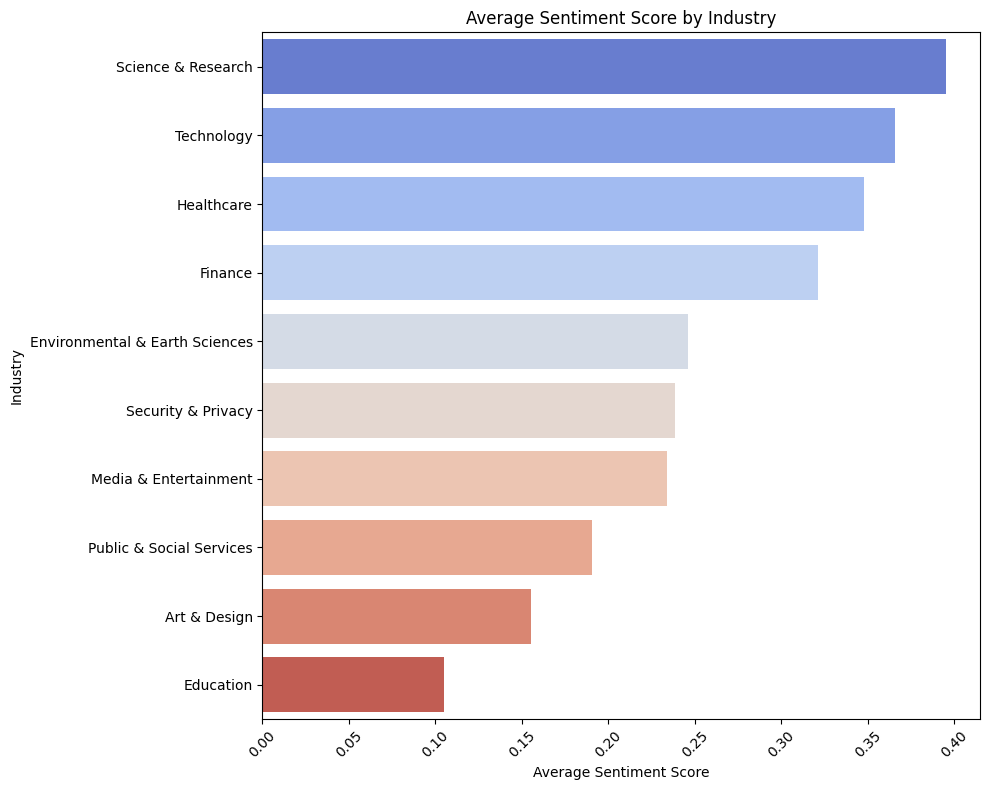

In [18]:
# Sort the industries by average sentiment score for better visualization
industry_sentiment_avg_sorted = industry_sentiment_avg.reset_index().sort_values(by='avg_sentiment', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='avg_sentiment', y='industry', data=industry_sentiment_avg_sorted, palette='coolwarm')
plt.title('Average Sentiment Score by Industry')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Industry')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- **Extract publication dates of the articles to analyze how sentiment and topic prevalence have changed over time.**

In [25]:
# Convert 'date' column to datetime
sentiment_loaded['date'] = pd.to_datetime(sentiment_loaded['date'])

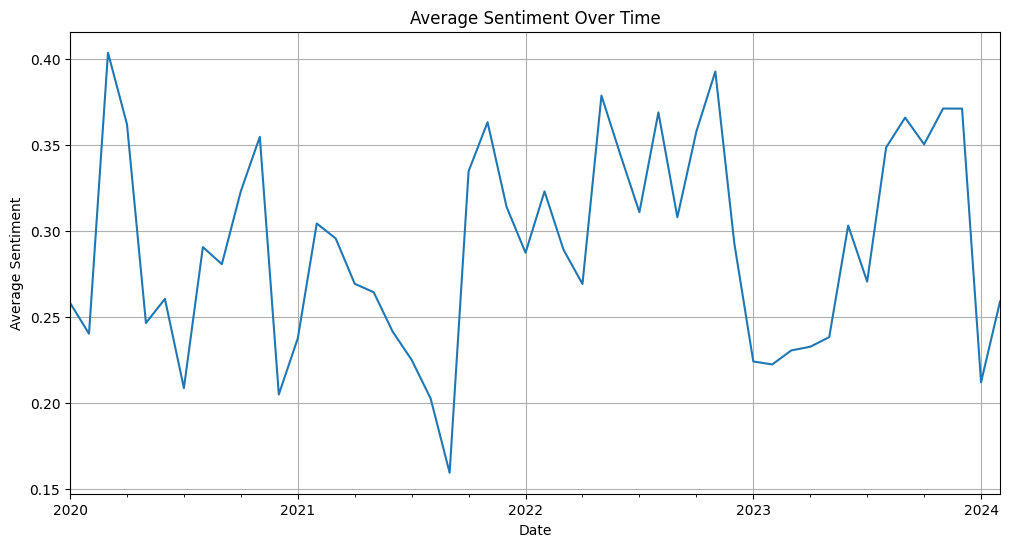

In [21]:
# Convert 'date' column to datetime
time_df = sentiment_loaded.copy()

# Set the 'date' column as the index of the DataFrame
time_df.set_index('date', inplace=True)

# Resample the data by month and compute the average sentiment
monthly_sentiment = time_df.resample('M')['avg_sentiment'].mean()

# Plot the average sentiment over time
plt.figure(figsize=(12, 6))
monthly_sentiment.plot(title='Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()


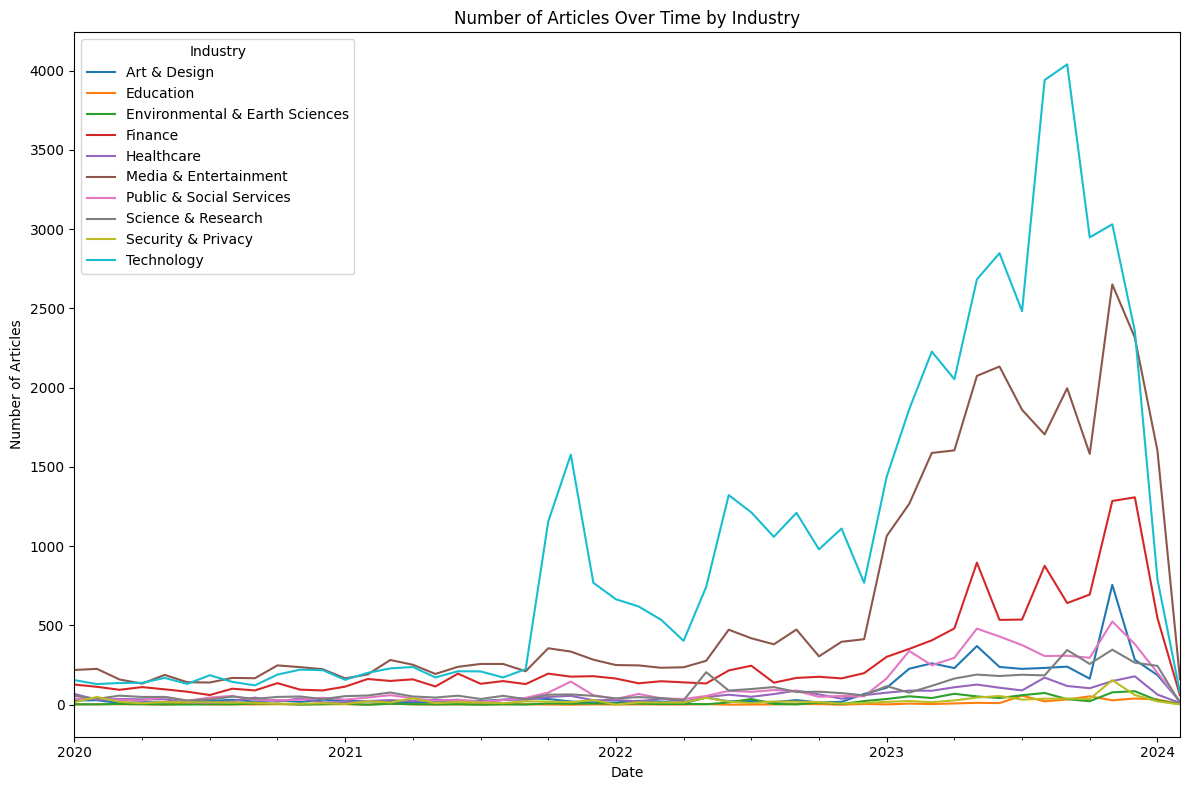

In [24]:
# Resample the data by month and count the number of articles per industry
monthly_counts = time_df.groupby('industry').resample('M').size()

# Unstack the industry levels for plotting
monthly_counts_unstacked = monthly_counts.unstack(level=0)

# Plot the data
monthly_counts_unstacked.plot(kind='line', figsize=(12, 8))

# Customizing the plot
plt.title('Number of Articles Over Time by Industry')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend(title='Industry')
plt.tight_layout() 
plt.show()

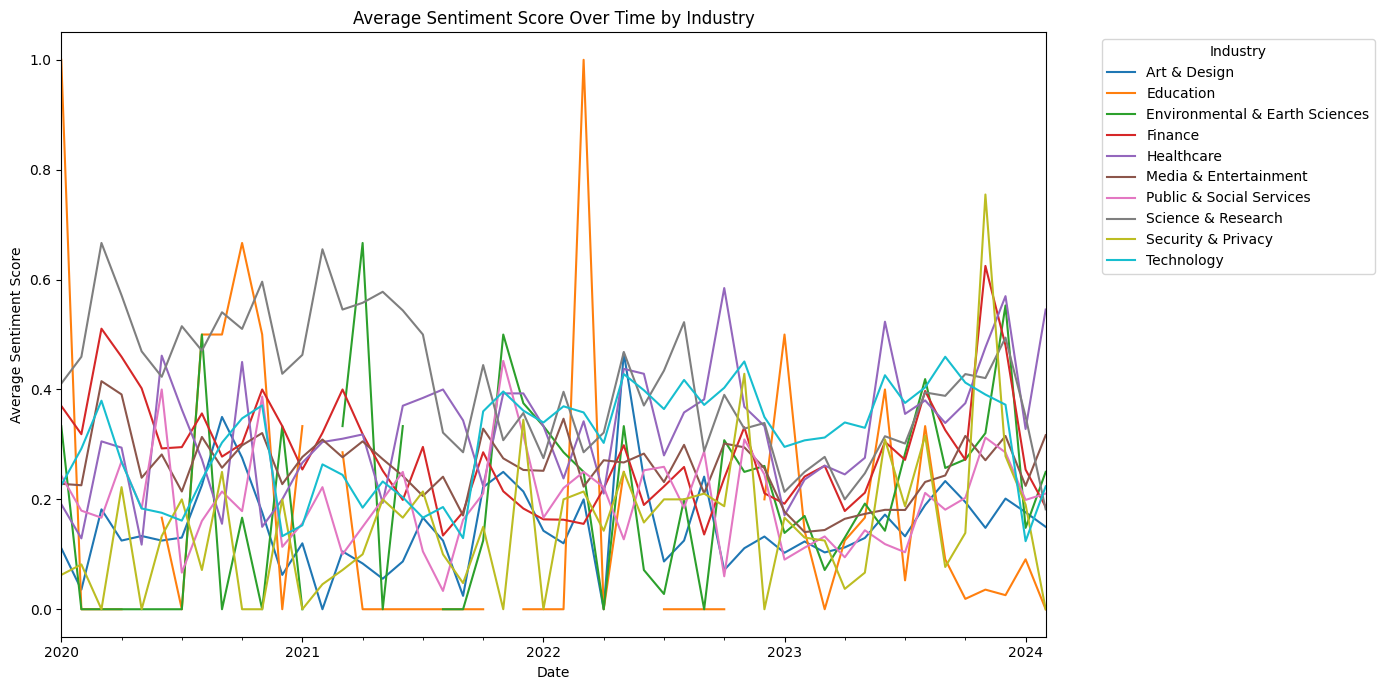

In [35]:
# Group by industry and date and calculate the mean sentiment
industry_sentiment_over_time = sentiment_loaded.groupby(['industry', 
                                                        pd.Grouper(key='date', freq = 'M')])['avg_sentiment'].mean().reset_index()

# Pivot the data for visualization
industry_sentiment_pivot = industry_sentiment_over_time.pivot(index = 'date', 
                                                              columns = 'industry', 
                                                              values = 'avg_sentiment')

# Plot
plt.figure(figsize=(14, 7))
industry_sentiment_pivot.plot(kind='line', ax=plt.gca())
plt.title('Average Sentiment Score Over Time by Industry')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 3.2 Based on sentiment and the nature of the topics, suggest which types of jobs are more vulnerable or can be enhanced by AI.

To suggest which types of jobs are more vulnerable or can be enhanced by AI, we need to consider the sentiment associated with AI within each industry, the nature of the tasks involved in those jobs, and the current capabilities of AI. Typically, jobs that involve routine tasks or tasks that can be codified into algorithms are more vulnerable to automation through AI. On the other hand, jobs that require creativity, complex problem-solving, and emotional intelligence may be enhanced by AI rather than replaced.

- **Create Job Functions**

In [36]:
job_function_keywords = {
    'Technology': ['developer', 'engineer', 'software', 'programmer', 'tech', 'IT specialist'],
    'Media & Entertainment': ['journalist', 'editor', 'producer', 'director', 'actor', 'writer', 'media'],
    'Finance': ['analyst', 'banker', 'finance', 'accountant', 'financial advisor', 'auditor'],
    'Public & Social Services': ['social worker', 'public servant', 'counselor', 'NGO', 'civil service'],
    'Science & Research': ['scientist', 'researcher', 'lab technician', 'academic', 'biologist', 'chemist'],
    'Art & Design': ['artist', 'designer', 'illustrator', 'photographer', 'creative'],
    'Healthcare': ['doctor', 'nurse', 'medical', 'healthcare', 'surgeon', 'physician'],
    'Security & Privacy': ['security analyst', 'cybersecurity', 'law enforcement', 'privacy officer'],
    'Environmental & Earth Sciences': ['environmentalist', 'geologist', 'ecologist', 'biologist', 'conservationist'],
    'Education': ['teacher', 'educator', 'professor', 'tutor', 'academic', 'instructor'],
}


# A function to infer job function from text
def infer_job_function(text, keyword_dict):
    for job_func, keywords in keyword_dict.items():
        if any(keyword in text.lower() for keyword in keywords):
            return job_func
    return 'Other'  

sentiment_loaded['job_function'] = sentiment_loaded['twt'].apply(infer_job_function, 
                                                                 keyword_dict = job_function_keywords)


- **Sentiment by Job Function Plot**

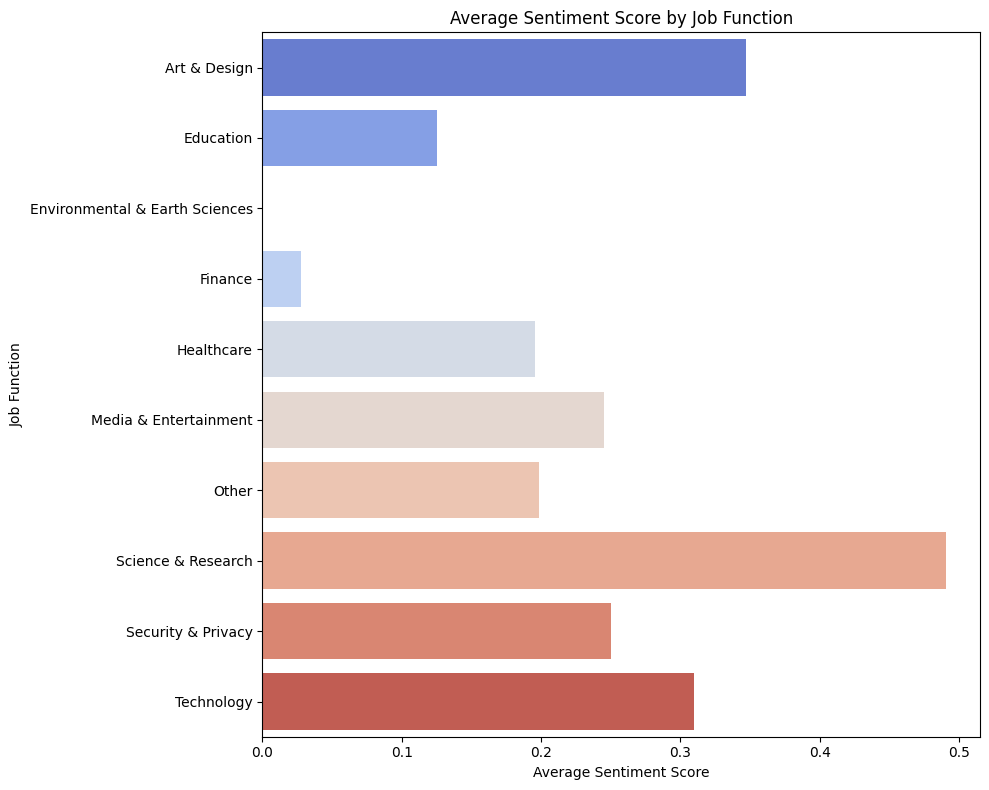

In [37]:
job_sentiment = sentiment_loaded.groupby('job_function')['avg_sentiment'].mean().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(data=job_sentiment, x='avg_sentiment', y='job_function', palette='coolwarm')
plt.title('Average Sentiment Score by Job Function')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Job Function')
plt.tight_layout()
plt.show()

# 4. Identify when new technologies and AI solutions (like image generation AI, Conversational AI) are mentioned to plot their emergence and predicted impact over time.

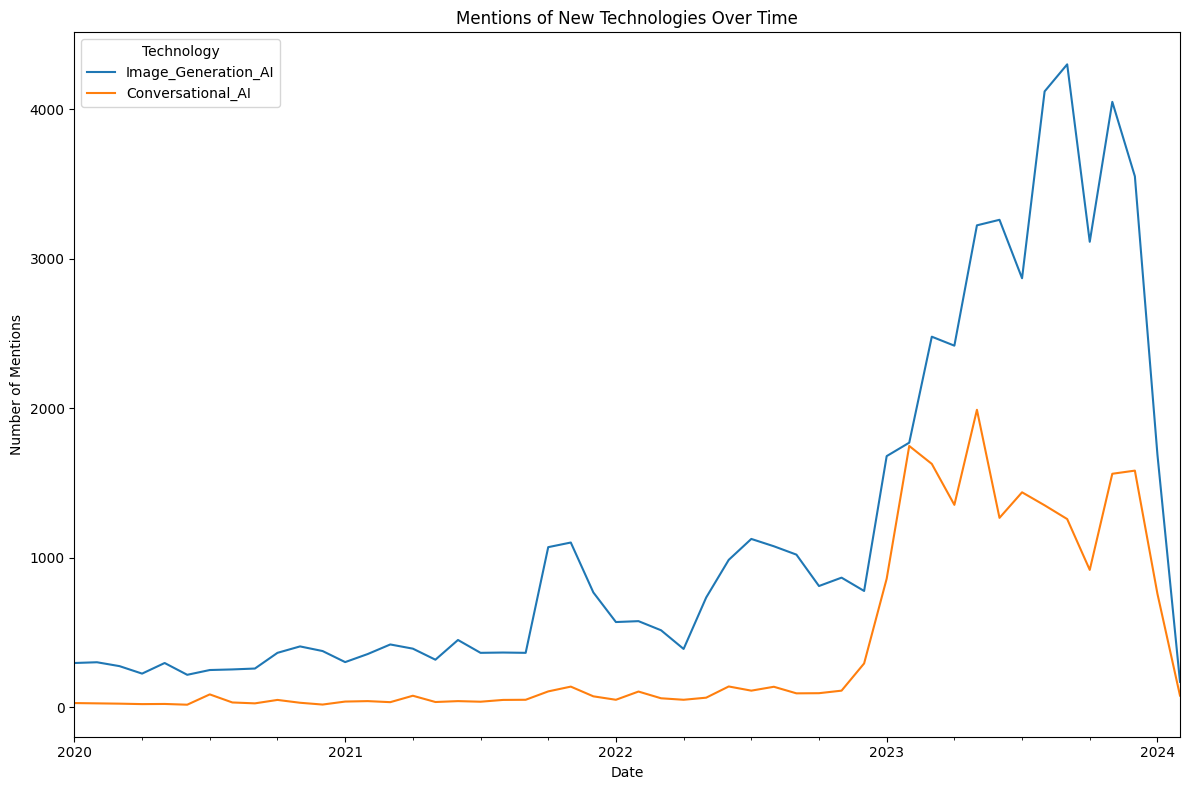

In [27]:
# Keywords related to new technologies and AI solutions
keywords = {
    'Image_Generation_AI': ['image generation', 'GAN', 'deepfake'],
    'Conversational_AI': ['conversational AI', 'chatbot', 'virtual assistant', 'dialogue systems']
}

# Initialize a dictionary to hold our time series data
technology_mentions = {tech: [] for tech in keywords}

# Search for keywords and group by time period
for tech, keyword_list in keywords.items():
    # Combine keywords into a single regex pattern
    pattern = '|'.join(keyword_list)
    
    # Filter rows where the text contains any of the keywords
    filtered_df = sentiment_loaded[sentiment_loaded['twt'].str.contains(pattern, 
                                                                        case = False, 
                                                                        na = False)]
    
    # Group by month (or another time period) and count occurrences
    monthly_counts = filtered_df.resample('M', on='date').size()
    
    # Store the time series data in our dictionary
    technology_mentions[tech] = monthly_counts

# Create a DataFrame from the dictionary
technology_trends = pd.DataFrame(technology_mentions)

# Plot
technology_trends.plot(kind='line', figsize=(12, 8))

# Customizing the plot
plt.title('Mentions of New Technologies Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Mentions')
plt.legend(title='Technology')
plt.tight_layout() 
plt.show()


# 5. Demonstrate what companies, academic institutions and government entities can do to accelerate the development of these transformative capabilities


## 5.1 Named Entity Recognition (NER)

Using spaCy for extracting organizations, locations, and people.

In [50]:
# Load SpaCy model
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['ORG', 'GPE', 'PERSON']]

def process_batch_and_save(batch, batch_index, save_path):
    # Process the batch
    batch['entities'] = [extract_entities(text) for text in batch['twt'].tolist()]
    
    # Save to Parquet
    batch.to_parquet(os.path.join(save_path, f'batch_{batch_index}.parquet'))

def process_and_save_in_batches(dataframe, batch_size=1000, save_path=f'{backup_chunk_dir}'):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    n_batches = len(dataframe) // batch_size + (1 if len(dataframe) % batch_size else 0)
    
    for i in range(n_batches):
        batch = dataframe[i*batch_size:(i+1)*batch_size]
        process_batch_and_save(batch, i, save_path)


process_and_save_in_batches(sentiment_loaded)


In [51]:
def combine_batches(save_path=f'{backup_chunk_dir}'):
    files = [os.path.join(save_path, file) for file in os.listdir(save_path) if file.endswith('.parquet')]
    dfs = [pd.read_parquet(file) for file in files]
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

# Combine saved batches into a single DataFrame
combined_df_ner = combine_batches()

# Save the combined DataFrame as a new Parquet file
combined_df_ner.to_parquet(f'{backup_dir}combined_sentiment_ner.parquet')


In [52]:
combined_df_ner.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118283 entries, 0 to 118282
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  118283 non-null  datetime64[ns]
 1   title                 118283 non-null  object        
 2   text                  118283 non-null  object        
 3   twot                  118283 non-null  object        
 4   twt                   118283 non-null  object        
 5   max_prediction_score  115407 non-null  float64       
 6   topic_id              118283 non-null  int64         
 7   topic_id_reduced      118283 non-null  int64         
 8   avg_sentiment         118283 non-null  int64         
 9   industry              118283 non-null  object        
 10  job_function          118283 non-null  object        
 11  risk_of_automation    118283 non-null  float64       
 12  entities              118283 non-null  object        
dtyp

In [5]:
combined_df_ner_loaded = pd.read_parquet(f'{backup_dir}combined_sentiment_ner.parquet', engine = 'pyarrow')

## 5.2 Aggregate Entities, Calculate Sentiment, and Store Entity Type

In [198]:
entity_sentiments = {}
for index, row in combined_df_ner_loaded.iterrows():
    for entity in row['entities']:
        if entity[1] in ['ORG', 'GPE', 'PERSON']:
            entity_name = entity[0]
            entity_type = entity[1]

            if entity_name not in entity_sentiments:
                
                entity_sentiments[entity_name] = {
                    'count': 1, 
                    'total_sentiment': row['avg_sentiment'],
                    'entity_type': entity_type  
                }
            else:
                entity_sentiments[entity_name]['count'] += 1
                entity_sentiments[entity_name]['total_sentiment'] += row['avg_sentiment']

# Convert to DataFrame for easier handling
entities_df = pd.DataFrame.from_dict(entity_sentiments, orient='index')
entities_df['average_sentiment'] = round(entities_df['total_sentiment'] / entities_df['count'], 1)


In [199]:
entities_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 981841 entries, Suspicious Gamers Think Dice to Invivyd, Inc.
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   count              981841 non-null  int64  
 1   total_sentiment    981841 non-null  int64  
 2   entity_type        981841 non-null  object 
 3   average_sentiment  981841 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 37.5+ MB


In [200]:
entities_df.head()

,count,total_sentiment,entity_type,average_sentiment
Suspicious Gamers Think Dice,1,0,PERSON,0.0
AI Bots,75,3,ORG,0.0
HotHardware,61,8,ORG,0.1
Suspicious Gamers Think Dice May Be Inflating Battlefield,1,0,ORG,0.0
HotHardware Skip,23,4,ORG,0.2


In [201]:
entities_df['average_sentiment'].value_counts()

average_sentiment
0.0    673552
1.0    186653
0.5     25854
0.2     20554
0.1     19455
0.3     16448
0.7      9558
0.4      8724
0.8      8708
0.6      7154
0.9      5181
Name: count, dtype: int64

In [379]:
# Manual mapping of entities to be merged
merge_entities = {
    'Digi Communications N.V.': ['DIGI COMMUNICATIONS N.V.', 
                                 'DIGI Communications N.V.', 
                                 'DIGI', 
                                 'Digi Communications NV',
                                 'CDP Institute Report Digi Communications N.V.',
                                 'the DQ Institute', 
                                 'DQ Institute'],
    'Google Workspace':['Duet AI',],
    'Gray Media Group, Inc.':['Gray Television', 'Gray Media Group'],
    'Intel':['Gaudi3'],
    'Associated Press':['AP', 'The Associated Press'],
    'Nexstar Media Inc.':['NexstarMedia'],
    'NPR News':['NPR'],
    'The New York Times':['Times']
}

# Function to merge entities based on the manual mapping
def merge_entity_sentiments(entity_sentiments, merge_entities):
    for primary_entity, entities_to_merge in merge_entities.items():
        for entity in entities_to_merge:
            if entity in entity_sentiments:
                if primary_entity not in entity_sentiments:
                    entity_sentiments[primary_entity] = entity_sentiments[entity]
                else:
                    entity_sentiments[primary_entity]['count'] += entity_sentiments[entity]['count']
                    entity_sentiments[primary_entity]['total_sentiment'] += entity_sentiments[entity]['total_sentiment']
                del entity_sentiments[entity]
    return entity_sentiments

# Merge the entities based on the manual mapping
entity_sentiments = merge_entity_sentiments(entity_sentiments, merge_entities)

# Recreate the entities_df DataFrame after merging
entities_df_clean = pd.DataFrame.from_dict(entity_sentiments, orient='index')
entities_df_clean['average_sentiment'] = round(entities_df_clean['total_sentiment'] / entities_df_clean['count'], 1)



In [380]:
entities_df.shape[0]

981841

## 5.3 Demonstrate what companies, academic institutions and government entities can do to accelerate the development of these transformative capabilities

- **Step 1: Filter Entities by Type and Positive Sentiment**

In [381]:
# Filter for organizations, geopolitical entities, and people with positive sentiment
positive_entities_df = entities_df_clean[(entities_df_clean['entity_type'].isin(['ORG', 'GPE', 'PERSON'])) \
                                   & (entities_df_clean['average_sentiment'] > 0.5)]

# Sort entities by their average sentiment and count to identify key contributors
key_positive_entities = positive_entities_df.sort_values(by = ['count', 'average_sentiment'], 
                                                         ascending = [False, False])


In [382]:
# Filter for organizations, geopolitical entities, and people with negative sentiment
negative_entities_df = entities_df_clean[(entities_df_clean['entity_type'].isin(['ORG', 'GPE', 'PERSON'])) \
                                   & (entities_df_clean['average_sentiment'] < 0.5)]

# Sort entities by their average sentiment and count to identify key contributors
key_negative_entities = negative_entities_df.sort_values(by = ['average_sentiment','count' ], 
                                                         ascending = [True, False])


In [383]:
positive_entities_df.head()

,count,total_sentiment,entity_type,average_sentiment
SambaNova,368,281,ORG,0.8
Bucharest,27,15,GPE,0.6
Size,1116,833,PERSON,0.7
Forecast,3312,2433,ORG,0.7
Request Free Sample Report,10,7,ORG,0.7


In [384]:
key_negative_entities.head()

,count,total_sentiment,entity_type,average_sentiment
Associated Press,33014,1014,ORG,0.0
NPR News,12864,455,ORG,0.0
LinkedIn Email,5980,293,PERSON,0.0
Environ,5750,86,ORG,0.0
The New York Times,5435,187,ORG,0.0


- **Step 2: Filter out organization entities that are companies, academic institutions, and government entities**

In [385]:
positive_orgs = key_positive_entities[key_positive_entities['entity_type'] == 'ORG']
negative_orgs = key_negative_entities[key_negative_entities['entity_type'] == 'ORG']

In [406]:
filtered_out_entities = ['Forecast', 'NSFW', 'Industry News', 
                         'TVLatest NewscastsPress', 'SWOT', 'Country Music',
                         'Company', 'NLP', 'Symbolic Language','Lucki',
                        'AI EYES', 'Heavy Industry', 'Application']

filtered_positive_orgs = positive_orgs.drop(filtered_out_entities, errors = 'ignore')

top_positive_orgs = filtered_positive_orgs.head(50)

top_positive_orgs

,count,total_sentiment,entity_type,average_sentiment
Digi Communications N.V.,16903,11329,ORG,0.7
CrushOn,4702,3411,ORG,0.7
TeraRecon,3279,1901,ORG,0.6
Supermicro,2422,1337,ORG,0.6
healthcare,2198,1361,ORG,0.6
KPMG,1522,906,ORG,0.6
FSA Regulation,1428,945,ORG,0.7
Pendo,1428,792,ORG,0.6
Google Workspace,1310,838,ORG,0.6
Blackbaud,917,701,ORG,0.8


In [407]:
filtered_negative_orgs = negative_orgs.drop(filtered_out_entities, errors = 'ignore')

top_negative_orgs = filtered_negative_orgs.head(50)
top_negative_orgs


,count,total_sentiment,entity_type,average_sentiment
Associated Press,33014,1014,ORG,0.0
NPR News,12864,455,ORG,0.0
Environ,5750,86,ORG,0.0
The New York Times,5435,187,ORG,0.0
BestReviews,4883,83,ORG,0.0
NewsNation,3379,32,ORG,0.0
Nexstar Media Inc.,3339,36,ORG,0.0
chevron,3268,81,ORG,0.0
MediaAll Entertain,3214,50,ORG,0.0
FTC,2746,113,ORG,0.0


- **Step 3: Recommendations for Accelerating AI Development**

In [408]:
def plot_sentiment_analysis(df, title = 'Top 20 Organizations Sentiment Analysis'):
   
    G = nx.Graph()
    
    # Add nodes with attributes
    for entity, data in df.iterrows():
        G.add_node(entity, sentiment = data['average_sentiment'], count = data['count'])
    
    # Get attributes for color and size
    sentiments = [G.nodes[node]['sentiment'] for node in G.nodes]
    counts = [G.nodes[node]['count'] for node in G.nodes]
    
    # Normalize sentiment for color mapping
    norm = colors.Normalize(vmin = min(sentiments), vmax = max(sentiments))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=norm)
    sm.set_array([]) 
    
    # Calculate node sizes
    sizes = [count  for count in counts] 
    
    # Draw the graph
    fig, ax = plt.subplots(figsize = (15, 10))  
    pos = nx.spring_layout(G)
    nx.draw(G, pos, ax=ax, with_labels=True, node_color=sentiments, cmap=plt.cm.RdYlGn, node_size=sizes)
    
    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad = 0.05)
    plt.colorbar(sm, cax = cax, label = 'Sentiment Score')
    
    # Set title and display
    plt.title(title)
    plt.show()


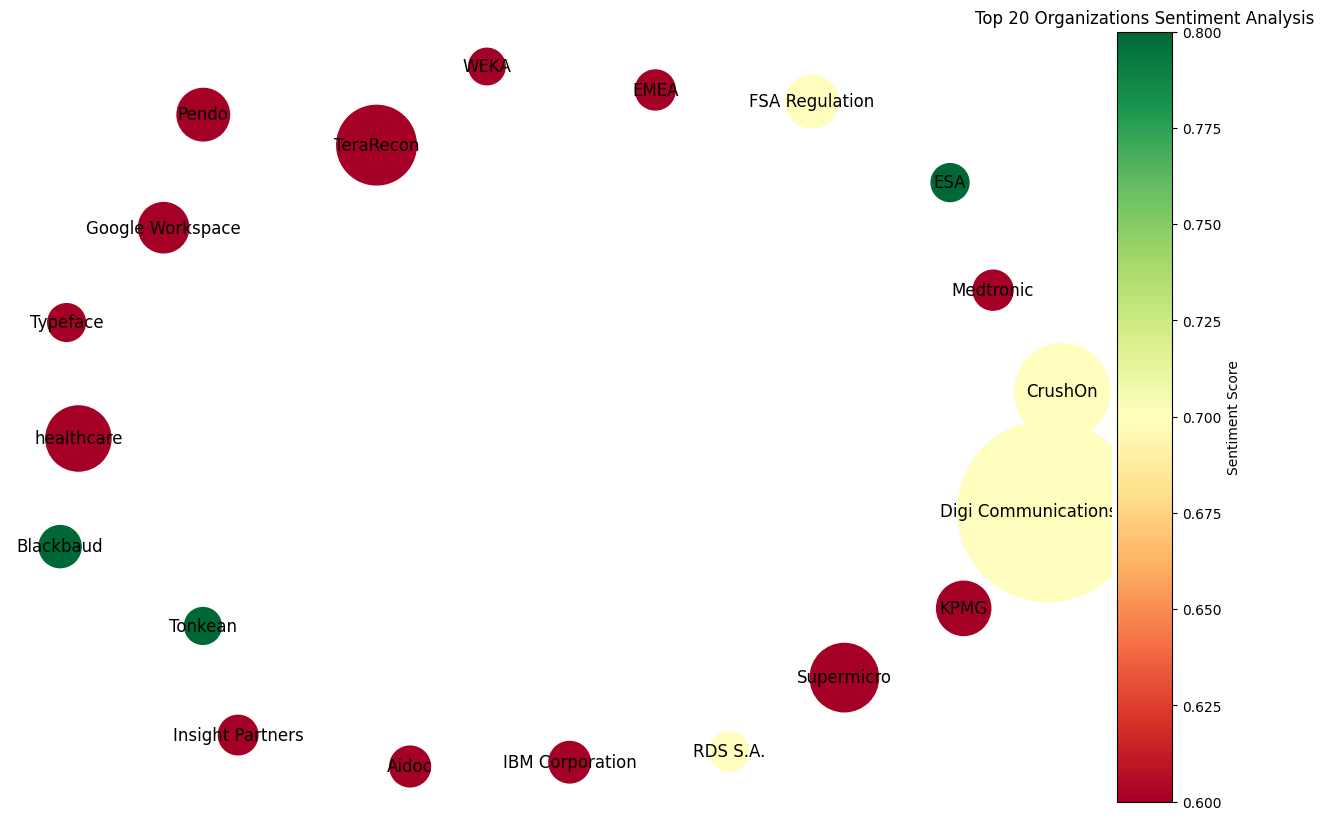

In [414]:
plot_sentiment_analysis(top_positive_orgs.head(20))


# 6. Leverage appropriate NLP techniques to identify organizations, people and locations, then apply targeted sentiment


## 6.1 What types of companies (based on the lines of business) are planning to invest in these technologies today or near future (success stories)?

In [410]:
from wordcloud import WordCloud

def create_word_cloud(entities, title):
    wordcloud = WordCloud(width = 800, height = 400, background_color='white').generate(' '.join(entities))
    plt.figure(figsize = (10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()



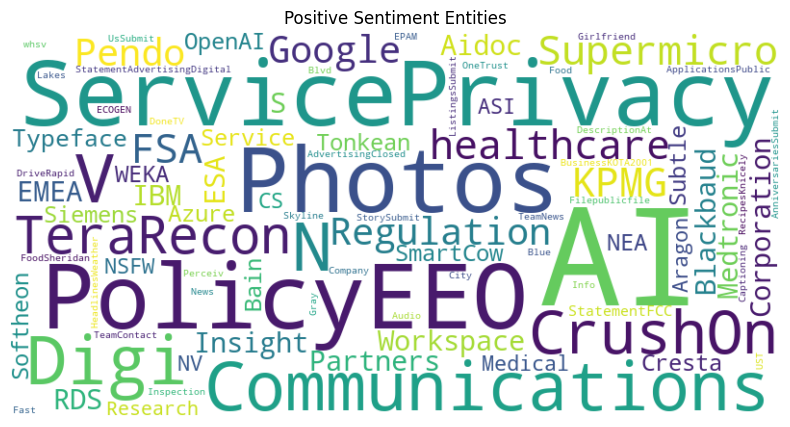

In [425]:
create_word_cloud(top_positive_orgs.index.to_list(), 'Positive Sentiment Entities')


## 6.2 What types of applications cannot currently be transformed by AI, based on today's state of technology (failures)?

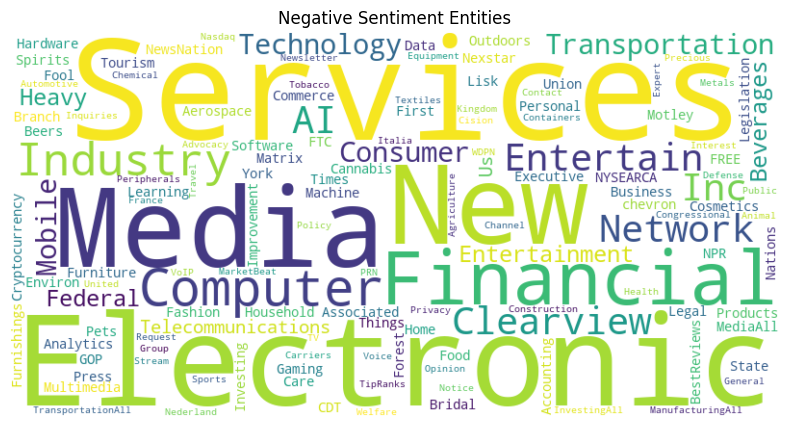

In [412]:
create_word_cloud(top_negative_orgs.index.to_list(), 'Negative Sentiment Entities')
